In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

SyntaxError: invalid syntax (4269583495.py, line 2)

In [2]:

import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
import numpy as np
from rasterio.enums import Resampling
import dask
from rasterstats import zonal_stats
import rioxarray as rxr

import torch.nn as nn

warnings.filterwarnings("ignore")

### Load mining data and visualize

In [47]:
# Load mine point data
mine_pts = gpd.read_file('data/pitlakes').to_crs(epsg=4326)

# Print info about dataset
print(mine_pts['Material'].value_counts())
print(len(mine_pts))
print(mine_pts['ID'].value_counts())

Material
coal         27
Al           24
Au           22
limestone    18
diamond      13
Fe           13
U             6
sand          4
phosphate     1
Cu            1
Name: count, dtype: int64
1004
ID
Ridgeway2    1
CC2          1
CC3          1
CC5          1
CC4          1
Pritzen      1
NULL+        1
Name: count, dtype: int64


In [523]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

In [525]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA['category']=='a')}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 11005'

4466
9625.4706495206
175949623.2529024
310764.76698829106
930940.420756829
557.4627942636989


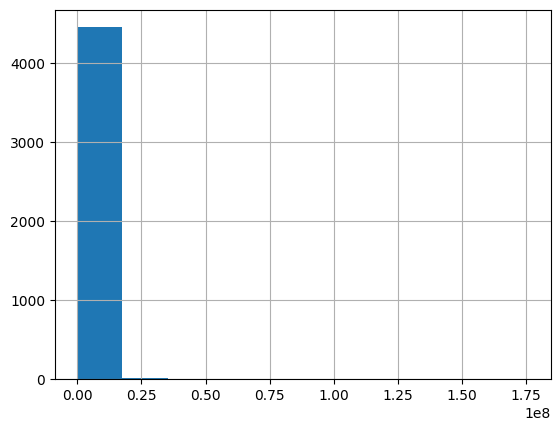

In [526]:
QA_global_mines = psql_bboxes[psql_bboxes['category']=='a']

QA_global_mines_gdf = gpd.GeoDataFrame(QA_global_mines, geometry = 'geometry', crs = 4326)

QA_global_mines_gdf = QA_global_mines_gdf.to_crs(epsg=9822)

pit_areas = QA_global_mines_gdf.geometry.area

pit_areas.hist(bins=10)

print(len(pit_areas))

print(pit_areas.min())
print(pit_areas.max())
print(pit_areas.median())
print(pit_areas.mean())

print(math.sqrt(pit_areas.median()))

0.7655620241827138
316.22776601683796
894.4271909999159
797
129532.97231740363
750606.8932339188


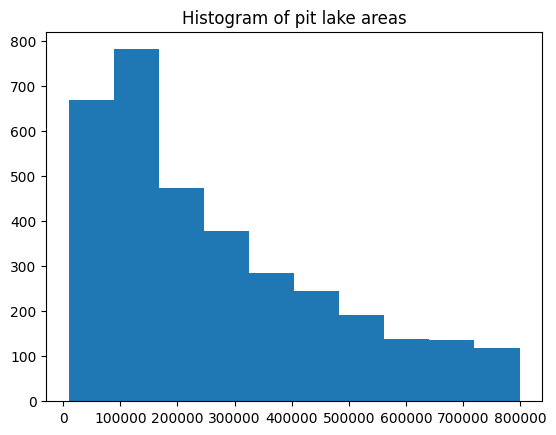

In [600]:
pit_areas_majority = pit_areas[pit_areas<(0.008*1e8)]
print(len(pit_areas_majority)/len(pit_areas))

plt.hist(pit_areas_majority,bins=10)
plt.title('Histogram of pit lake areas')
#plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])

#plt.show()

mode_length = math.sqrt(0.1*1e6)
print(mode_length)
print(math.sqrt(800000))
print(len(pit_areas[pit_areas<(100000)]))

import scipy
print(np.percentile(pit_areas, 25))
print(np.percentile(pit_areas, 75))


In [ ]:
pit_areas_majority = pit_areas[pit_areas<(0.008*1e8)]


In [99]:
# Load mine polygons from Tang dataset(?) and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


<Axes: >

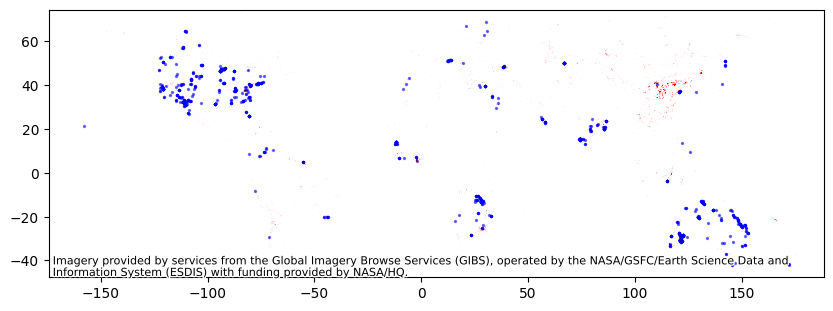

In [137]:
# Visualize with satellite basemap
providers = cx.providers.flatten()

# Visualize mine point data
ax = mine_pts.plot(column = 'Material', 
    markersize = 2,
    color = 'blue', 
    legend = True, 
    legend_kwds={'bbox_to_anchor': (1, 1)},
    figsize = (10,10),
    alpha = 0.5)
cx.add_basemap(ax, crs=mine_pts.crs, source=providers['NASAGIBS.BlueMarble'])

mine_poly.plot(ax=ax, color = 'red', linewidth = 6)

In [54]:
# Keep only polygons with confirmed mine point from Aquarry
# mine_pts_polys = gpd.sjoin(mine_poly, mine_pts, how = 'inner', predicate = "intersects")

In [527]:
# Get pit lakes in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union # MN was multipolygon

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')

MN QAed mines: 87


In [670]:
# Get pit lakes in AZ

states = gpd.read_file('data/state_boundaries')
az = states[states['STUSPS']=='AZ']
az = az.to_crs(epsg = 4326).geometry.unary_union

#az_mines_pts = mine_pts[mine_pts.geometry.within(az)]
#az_mines_poly = mine_poly[mine_poly.geometry.intersects(az)]
#az_mines_intersect = mine_pts_polys[mine_pts_polys.geometry.intersects(az)] # Only keep polygons with confirmed Aquarry points

az_qa = US_QA[US_QA.geometry.intersects(az)]
print(f'AZ QAed mines: {(az_qa['category'] == 'a').sum()}')

AZ QAed mines: 56


In [1027]:
# Get pit lakes in OH, KY, WV

states = gpd.read_file('data/state_boundaries')
oh = states[states['STUSPS']=='OH']
oh = oh.to_crs(epsg = 4326).geometry.unary_union

oh_qa = US_QA[US_QA.geometry.intersects(oh)]
print(f'OH QAed mines: {(oh_qa['category'] == 'a').sum()}')

ky = states[states['STUSPS']=='KY']
ky = ky.to_crs(epsg = 4326).geometry.unary_union

ky_qa = US_QA[US_QA.geometry.intersects(ky)]
print(f'KY QAed mines: {(ky_qa['category'] == 'a').sum()}')

wv = states[states['STUSPS']=='WV']
wv = wv.to_crs(epsg = 4326).geometry.unary_union
wv_qa = US_QA[US_QA.geometry.intersects(wv)]
print(f'WV QAed mines: {(wv_qa['category'] == 'a').sum()}')

OH QAed mines: 57
KY QAed mines: 70
WV QAed mines: 41


In [58]:
# Hold out Miami AZ

miami_az = gpd.read_file('data/miami_az_pits.geojson')
az_mines_intersect = az_mines_intersect[~az_mines_intersect.geometry.within(miami_az.geometry.iloc[0])]

print(len(az_mines_intersect))

az_qa = az_qa[~az_qa.geometry.intersects(miami_az.geometry.iloc[0])]

42


#### Get MN waterbody data and separate mines / other bodies of water

In [16]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']

dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

dnr_pit_lakes.head()


200
130746


,wb_class,shape_Area,geometry
411,Natural Ore Mine,1.069300e+05,"POLYGON ((-92.69807 47.51515, -92.69809 47.515..."
1089,Natural Ore Mine,1.319908e+04,"POLYGON ((-92.56445 47.4694, -92.56435 47.4693..."
1156,Mine Pit Lake (NF),1.886662e+05,"POLYGON ((-94.00199 46.48612, -94.00145 46.485..."
1228,Mine Pit Lake,1.145849e+07,"POLYGON ((-92.64102 47.55076, -92.64056 47.550..."
2000,Natural Ore Mine,3.979919e+04,"POLYGON ((-92.74355 47.51982, -92.74342 47.519..."


In [117]:
mn_qa_pits = mn_qa[mn_qa['category']=='a']
overlap_check = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["objectid"])
print(f"% of mine QA'ed data with overlapping polygon from MN DNR: {len(overlap_check)/len(mn_qa_pits)*100}")

overlap_check = gpd.sjoin(dnr_pit_lakes, mn_qa_pits, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["geometry"])
print(f"% of DNR polygons with overlapping mine QA'ed data: {len(overlap_check)/len(dnr_pit_lakes)*100}")


% of mine QA'ed data with overlapping polygon from MN DNR: 63.2183908045977
% of DNR polygons with overlapping mine QA'ed data: 28.999999999999996


<Axes: >

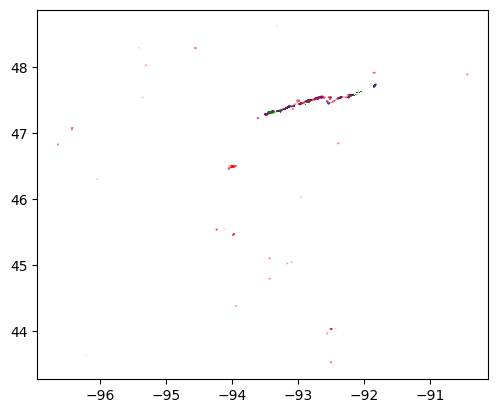

In [119]:
#Visualize overlap of Minnesota Aquarry QAed mines and DNR polygons
providers = cx.providers.flatten()

overlap = gpd.sjoin(dnr_pit_lakes,mn_qa_pits,how = "inner",rsuffix="1")

ax = overlap.plot(edgecolor = 'blue')
dnr_pit_lakes.plot(ax = ax,edgecolor = 'red', alpha = 0.5)
mn_qa_pits.plot(ax = ax, color = 'green',markersize = 1)

In [17]:
# Hold out Crosby MN

crosby_mn = gpd.read_file('data/crosby_mn.geojson')
dnr_pit_lakes = dnr_pit_lakes[~dnr_pit_lakes.geometry.intersects(crosby_mn.geometry.iloc[0])]
mn_qa = mn_qa[~mn_qa.geometry.intersects(crosby_mn.geometry.iloc[0])]
dnr_water = dnr_water[~dnr_water.geometry.intersects(crosby_mn.geometry.iloc[0])]

print((mn_qa['category']=='a').sum())
print(len(dnr_water))

87
129133


#### Visualize AZ and MN mines

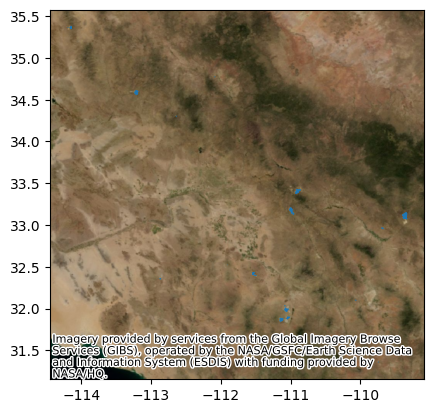

In [ ]:
# Visualize AZ pit lakes
providers = cx.providers.flatten()

ax = az_mines_intersect.plot()
cx.add_basemap(ax, crs=az_mines_intersect.crs, source=providers['NASAGIBS.BlueMarble'])

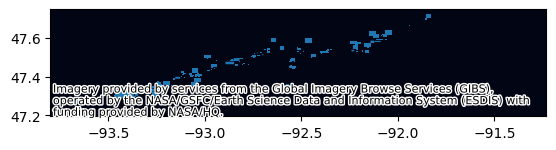

In [66]:
# Visualize MN pit lakes
providers = cx.providers.flatten()

ax = mn_qa.plot()
cx.add_basemap(ax, crs=mn_qa.crs, source=providers['NASAGIBS.BlueMarble'])

#### Check on handling of clouds


In [57]:
# UNFINISHED 

def ReadEmbeddingsFromFolder(folder_path):
    """ 
    
    Parameters:
    folder_path (str): folder with embeddings
    
    Returns:
    """
    folders = []
    embeddings = []

    # Go through all embedding folders
    folder_list = os.listdir(folder_path)

    # Get list of folders to search through
    for folder in folder_list: 
        folders.append(f"{folder_path}{folder}")

    # In each folder, go through parquet files and add file to list
    for folder in folders: 
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        
        for file in parquet_files:
            .append(file)
    


    return embeddings

In [94]:
# Grab a cloudy scene 
# 7/30 is very cloudy, 7/27 has clouds in top left corner

cloudy_scene = "data/MN_v1_5/UL/2024/7/S2B_15TUL_20240730_0_L2A/S2B_15TUL_20240730_0_L2A.parquet"

cloudy_scene_chips = gpd.read_parquet(cloudy_scene)
cloudy_scene_chips = gpd.GeoDataFrame(cloudy_scene_chips).set_crs(epsg=4326)

print(len(cloudy_scene_chips))

# Perform PCA on scene
cloudy_pca = EmbeddingsPCA(cloudy_scene_chips)

484
Relative variance in principal components: [0.2692709]


<Axes: >

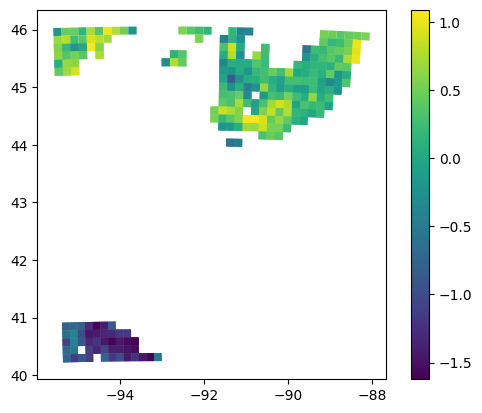

In [95]:
# Visualize scene PCA

cloudy_pca.plot(column='pca1', legend=True)

Text(0.5, 1.0, 'PCA of Cloudy Scene Embeddings')

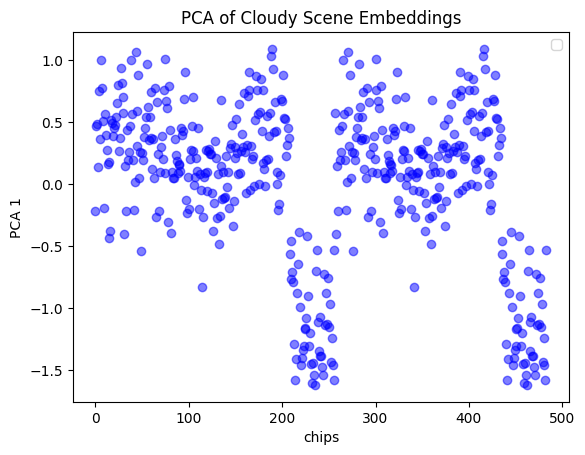

In [72]:
# Visualize the first principal component
fig, ax = plt.subplots()

    # Plot for category 1
ax.scatter(cloudy_pca.index,
    cloudy_pca[cloudy_pca['clouds'] == True]['pca1'], 
           color='blue', alpha=0.5)

    # Plot for category 2
#ax.scatter(cloudy_pca.index,
#    cloudy_pca[cloudy_pca['clouds'] == False]['pca1'], 
#           color='grey', alpha=0.05)
    
""" EDIT SO CAN SEE WHAT THE LITTLE OVERLAP IS  plt.scatter(data[data['wb_'] == new_condition]['pca1'], 
            data[data[new_class_column] == new_condition]['pca2'], 
            color='red', label=label3, alpha=0.5, marker='^') """

plt.xlabel('chips')
plt.ylabel('PCA 1')
ax.legend()
plt.title('PCA of Cloudy Scene Embeddings')


#### Grab embeddings for mines and random embeddings

In [686]:
# DEPRECATED
# Define function for getting embedding files that intersect with polygons of interest

def GetEmbeddingsFromIntersection(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) image files with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embeddings
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of embedding gpq file names """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []
    folders = []

    # Go through all embedding folders
        # Folder structure: Grid zone, year, month, embedding folder, parquet file
    folder_list = os.listdir(folder_path)

    import random

    # Get list of folders to search through
    for folder in folder_list: 
        folders.append(f"{folder_path}{folder}")

    # In each folder, go through parquet files and add file to list if it contains mines
    for folder in folders: 
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]

        # Check if image has any intersecting chips
        for file in parquet_files:
            pqs = gpd.read_parquet(file, columns=["geometry"])
            if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                positive_embeddings.append(file)
            else: 
                if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                    negatives_list.append(file)
                                
        if random_images == True:
            # Set up to get random images
            index = np.array(random.sample(range(1, len(negatives_list)), count))

            for i in index:
                negative_embeddings.append(negatives_list[i])           
            print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [111]:
# Define function for getting embedding files that intersect with polygons of interest

def GetEmbeddingsFromIntersection1_5(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) scene file names with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embedding gpqs
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of scenes  """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []

    # Go through all embedding folders
    # Folder structure: Grid zone, year, month, embedding folder, parquet file
    grid_zone_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for grid_zone_folder in grid_zone_folders:
        grid_zone = os.path.basename(grid_zone_folder)
        # Get list of year folders
        year_folders = [os.path.join(grid_zone_folder, year) for year in os.listdir(grid_zone_folder) if os.path.isdir(os.path.join(grid_zone_folder, year))]
    
        for year_folder in year_folders:
            year = os.path.basename(year_folder)
            # Get list of month folders
            month_folders = [os.path.join(year_folder, month) for month in os.listdir(year_folder) if os.path.isdir(os.path.join(year_folder, month))]
            
            for month_folder in month_folders:
                month = os.path.basename(month_folder)
                year_month = f"{year}_{month}"
                    
                # Get list of embedding folders
                embedding_folders = [os.path.join(month_folder, embedding) for embedding in os.listdir(month_folder) if os.path.isdir(os.path.join(month_folder, embedding))]
                
                for embedding_folder in embedding_folders:
                    # Get all parquet files in the embedding folder
                    parquet_files = [os.path.join(embedding_folder, f) for f in os.listdir(embedding_folder) if f.endswith(".parquet")]

                    parquet_files_details = []

                    # Append parquet file details with grid zone and year_month to the list
                    for parquet_file in parquet_files:
                        parquet_files_details.append({
                            "file_path": parquet_file,
                            "grid_zone": grid_zone,
                            "year_month": year_month
                        })

                    # In each folder, go through parquet files and add file to list if it contains mines
                    # Check if image has any intersecting chips
                    for file in parquet_files_details:
                        if os.path.getsize(file['file_path']) > 0:
                           pqs = gpd.read_parquet(file['file_path'], columns=["geometry"])
                        else:
                            print(f"Skipping empty file: {file['file_path']}")
                        if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                            positive_embeddings.append(file)
                        else: 
                            if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                                negatives_list.append(file)
                                            
                    if random_images == True:
                        # Set up to get random images
                        index = np.array(random.sample(range(1, len(negatives_list)), count))

                        for i in index:
                            negative_embeddings.append(negatives_list[i])           
                        print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [306]:
# Get embeddings for pit lakes and no pit lakes present in AZ

mine_embeddings_az, non_mine_embeddings_az = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_mines_intersect)

print("Number of images with mines:")
print(len(mine_embeddings_az))

Random images: 2
Number of images with mines:
3


In [ ]:
# Get embeddings for pit lakes and no pit lakes present in AZ from QA data

az_qa_pits = az_qa[az_qa['category'] == 'a'] # QAed pit lakes 
az_qa_nonlakes = az_qa[~az_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_az, non_mine_embeddings_az = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_qa_lakes, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_az)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_az)}")


# Get embeddings for water bodies in AZ
az_lakes = gpd.read_file('data/az_lakes.txt')
lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_lakes, random_images=False)

print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of images with mines: 3010
Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of negative mine images: 3287
Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of images with lakes: 1983


In [870]:
# Combine Aquarry QA and DNR data to check for intersection

mn_qa_pits = mn_qa[mn_qa['category'] == 'a'] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")

# Get embedding files for pit lakes in MN in DNR or Aquarry dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_aggregated_pits, random_images = False)
print(f"Number of images with mines: {len(mine_embeddings_mn)}")


Number of images with mines: 125


In [688]:
# TESTING
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = mn_aggregated_pits, random_images = False)


In [710]:
# DEPRECATED
# Make monthly aggregates
# USE IF GEOMETRIES DON'T OVERLAP TOO MUCH

def MonthlyComposite(embeddings_df):

    monthly_average_embeddings = gpd.GeoDataFrame()

    for zone in embeddings_df['grid_zone'].unique():
        zone_embeddings = pd.DataFrame(embeddings_df[embeddings_df['grid_zone'] == str(zone)])

        month_aggregate = gpd.GeoDataFrame()
        
        for index, row in zone_embeddings.iterrows():
             # Will need to adjust when more months are available
            chip_embeddings = gpd.read_parquet(row['file_path'])
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            month_aggregate = pd.concat([month_aggregate,chip_embeddings])

            grouped = month_aggregate.groupby('geometry')

            chip_embeddings_agg = grouped['embeddings'].apply(list).reset_index()
            chip_embeddings_agg_gdf = gpd.GeoDataFrame(chip_embeddings_agg, geometry='geometry')

            chip_embeddings_agg_gdf['monthly_average'] = chip_embeddings_agg_gdf['embeddings'].apply(
                lambda x: np.mean(np.vstack(x), axis=0))

            chip_embeddings_agg_gdf['grid_zone'] = zone
            chip_embeddings_agg_gdf['year_month'] = zone_embeddings['year_month'].iloc[0]

            monthly_average_embeddings = pd.concat([monthly_average_embeddings, chip_embeddings_agg_gdf])

    return monthly_average_embeddings


In [1069]:
# Make monthly aggregates without averaging
# USE IF GEOMETRIES OVERLAP

def MonthlyComposite(embeddings_df, polygons = None):

    monthly_agg_embeddings = gpd.GeoDataFrame()

    for zone in embeddings_df['grid_zone'].unique(): # For each UTM zone
        zone_embeddings = pd.DataFrame(embeddings_df[embeddings_df['grid_zone'] == str(zone)])
        count = 1

        for index, row in zone_embeddings.iterrows(): # For each date within UTM zone
             # Will need to adjust when more months are available, currently just goes through whole list
            chip_embeddings_agg_gdf = gpd.GeoDataFrame()
            non_intersecting_chips = gpd.GeoDataFrame()
            chip_embeddings = gpd.read_parquet(row['file_path'])
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)

            if len(chip_embeddings) > 2000: # If the image is not very cloudy
                if polygons is not None: # Don't include chips that don't correspond to the polygons
                    polys_geometry = polygons.unary_union
                    chip_embeddings = chip_embeddings[chip_embeddings.intersects(polys_geometry)]
                
                if not monthly_agg_embeddings.empty:
                    # Get all chips that aren't already in the aggregation
                    chips_intersection = gpd.sjoin(chip_embeddings, monthly_agg_embeddings, how="left", predicate="intersects")
                    non_intersecting_chips = chips_intersection[chips_intersection.index_right.isna()].drop(columns=["index_right", "embeddings_right","grid_zone","year_month"])
                    chip_embeddings_agg_gdf = non_intersecting_chips.rename(columns={'embeddings_left': 'embeddings'})

                    # Add chips that intersect with aggregation that are less than 25% overlapping
                    intersecting_chips = chips_intersection[~chips_intersection.index_right.isna()].drop(columns=["index_right", "embeddings_right","grid_zone","year_month"])
                    intersecting_chips['chip_area'] = intersecting_chips.geometry.area
                    intersections = intersecting_chips.geometry.apply(lambda g: g.intersection(monthly_agg_embeddings_unified))
                    intersecting_chips['area_overlap'] = intersections.area
                    low_intersection_mask = (intersecting_chips['area_overlap'] / intersecting_chips['chip_area']) < 0.25
                    low_intersection_chips = intersecting_chips[low_intersection_mask].rename(columns={'embeddings_left': 'embeddings'}).drop(columns = ['chip_area','area_overlap'])

                    # Add chips with small overlap to aggregated embeddings
                    chip_embeddings_agg_gdf = pd.concat([chip_embeddings_agg_gdf,low_intersection_chips])
                else:
                    non_intersecting_chips = chip_embeddings
                    chip_embeddings_agg_gdf = gpd.GeoDataFrame(non_intersecting_chips['embeddings'], columns = ['embeddings'], geometry=non_intersecting_chips['geometry'])
                chip_embeddings_agg_gdf['grid_zone'] = zone
                chip_embeddings_agg_gdf['year_month'] = zone_embeddings['year_month'].iloc[0]
                monthly_agg_embeddings = pd.concat([monthly_agg_embeddings, chip_embeddings_agg_gdf])
                monthly_agg_embeddings_unified = monthly_agg_embeddings.unary_union
                count = count + 1 
                if count == 3: # Check two images without clouds
                    count = 1
                    break
    
    monthly_agg_embeddings.to_crs(epsg=4326)
    monthly_agg_embeddings = monthly_agg_embeddings.drop_duplicates('geometry')

    return monthly_agg_embeddings


#### Arizona

In [672]:
# Get average of monthly embeddings for pit lake embeddings in AZ
mine_embeddings_az_df = pd.DataFrame(mine_embeddings_az, columns = ['file_path','grid_zone','year_month'])

az_positive_embs_avg = MonthlyComposite(mine_embeddings_az_df)
print(len(az_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
lake_embeddings_az_df = pd.DataFrame(lake_embeddings_az, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_az_df = pd.DataFrame(qa_non_mine_embeddings_az, columns = ['file_path','grid_zone','year_month'])

az_water_embs_avg = MonthlyComposite(lake_embeddings_az_df)
az_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_az_df)
print(len(az_water_embs_avg))
print(len(az_negative_embs_avg))

5613
4710
5570


<Axes: >

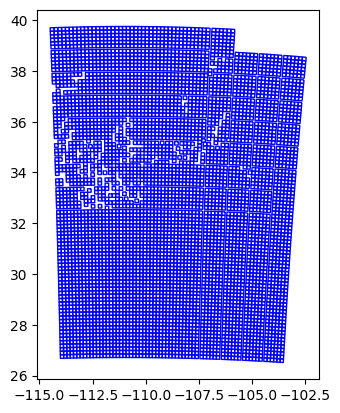

In [937]:
#Check overlap
fig, ax = plt.subplots()
az_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")

#az_negative_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


#### Indiana

In [993]:
# Get pit lakes in IN

states = gpd.read_file('data/state_boundaries')
indy = states[states['STUSPS']=='IN']
indy = indy.to_crs(epsg = 4326).geometry.unary_union

in_qa = US_QA[US_QA.geometry.intersects(indy)]
print(f'IN QAed mines: {(in_qa['category'] == 'a').sum()}')

IN QAed mines: 149


In [994]:
# Get embeddings for pit lakes and no pit lakes present in IN from QA data

in_qa_pits = in_qa[in_qa['category'] == 'a'] # QAed pit lakes 
in_qa_nonlakes = in_qa[~in_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_in, non_mine_embeddings_in = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = in_qa_pits, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_in)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_in, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = in_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_in)}")

# Get embeddings for water bodies in IN
#az_lakes = gpd.read_file('data/az_lakes.txt')
#lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = az_lakes, random_images=False)

#print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Number of images with mines: 176
Number of negative mine images: 153


In [995]:
# Get average of monthly embeddings for pit lake embeddings in IN
mine_embeddings_in_df = pd.DataFrame(mine_embeddings_in, columns = ['file_path','grid_zone','year_month'])

in_positive_embs_avg = MonthlyComposite(mine_embeddings_in_df)
print(len(in_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
#lake_embeddings_in_df = pd.DataFrame(lake_embeddings_in, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_in_df = pd.DataFrame(qa_non_mine_embeddings_in, columns = ['file_path','grid_zone','year_month'])

#az_water_embs_avg = MonthlyComposite(lake_embeddings_in_df)
in_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_in_df)
#print(len(in_water_embs_avg))
print(len(in_negative_embs_avg))

next zone
next zone
next zone
next zone
2296
next zone
next zone
next zone
next zone
2296


<Axes: >

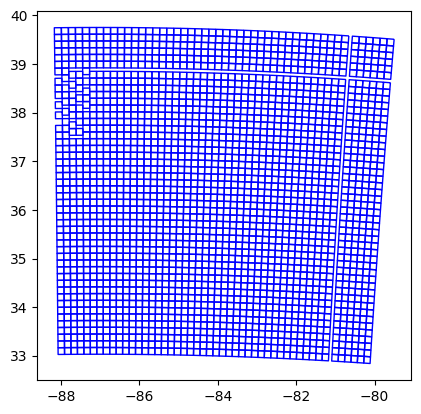

In [996]:
#Check mines chips
fig, ax = plt.subplots()
in_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


#### Kentucky

In [1074]:
# Get embeddings for pit lakes and no pit lakes present in IN from QA data

ky_qa_pits = ky_qa[ky_qa['category'] == 'a'] # QAed pit lakes 
ky_qa_nonlakes = ky_qa[~ky_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_ky, non_mine_embeddings_in = GetEmbeddingsFromIntersection1_5(folder_path = 'data/KY_v1_5/', polygons = ky_qa_pits, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_ky)}")

# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_ky, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/KY_v1_5/', polygons = ky_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_ky)}")

# Get embeddings for water bodies in IN
#az_lakes = gpd.read_file('data/az_lakes.txt')
#lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = az_lakes, random_images=False)

#print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Number of images with mines: 207
Number of negative mine images: 203


In [1075]:
# Get average of monthly embeddings for pit lake embeddings in IN
mine_embeddings_ky_df = pd.DataFrame(mine_embeddings_ky, columns = ['file_path','grid_zone','year_month'])

ky_positive_embs_avg = MonthlyComposite(mine_embeddings_ky_df)
print(len(ky_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
#lake_embeddings_in_df = pd.DataFrame(lake_embeddings_in, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_ky_df = pd.DataFrame(qa_non_mine_embeddings_ky, columns = ['file_path','grid_zone','year_month'])

#az_water_embs_avg = MonthlyComposite(lake_embeddings_in_df)
ky_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_ky_df)
#print(len(in_water_embs_avg))
print(len(ky_negative_embs_avg))

3578
3578


<Axes: >

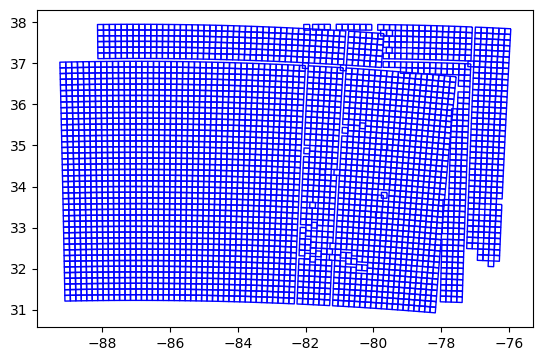

In [1076]:
#Check mines chips
fig, ax = plt.subplots()
ky_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")

#### Minnesota

In [991]:
# Get monthly embeddings for pit lake embeddings in MN
mine_embeddings_mn_df = pd.DataFrame(mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_positive_embs_avg = MonthlyComposite(mine_embeddings_mn_df, mn_aggregated_pits)
len(mn_positive_embs_avg)

next zone
next zone
next zone
next zone
next zone
next zone
next zone
next zone
next zone
next zone
next zone


30

<Axes: >

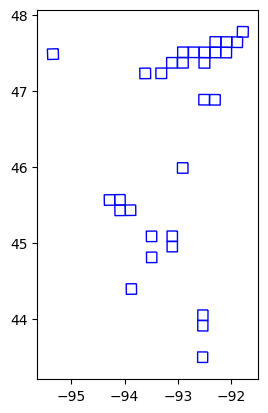

In [992]:
#Check overlap
fig, ax = plt.subplots()
mn_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


In [150]:
# Get embeddings for pit lakes in MN in DNR dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = dnr_pit_lakes, random_images = False)

print(f"Number of images with mines: {len(mine_embeddings_mn)}")


Number of images with mines:
79


In [921]:
mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)

# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]

dnr_water_cropped = dnr_water_cropped[~dnr_water_cropped.geometry.intersects(crosby_mn.geometry.iloc[0])] # Remove any Crosby lakes

lake_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = dnr_water_cropped, random_images = False)
print(f"Number of images with water that's not mines: {len(lake_embeddings_mn)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_qa_nonlakes, random_images = False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_mn)}")

Number of images with water that's not mines: 175
Number of negative mine images: 28


In [ ]:
# Get monthly embeddings for water and non-pit lake embeddings in MN
lake_embeddings_mn_df = pd.DataFrame(lake_embeddings_mn, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_mn_df = pd.DataFrame(qa_non_mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_water_embs_avg = MonthlyComposite(lake_embeddings_mn_df, dnr_water_cropped)
mn_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_mn_df, mn_qa_nonlakes)

geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next z

#### Label embeddings with mine/no mine

In [ ]:
# Add buffer to make mine polygon
#buffered_mines = gpd.GeoDataFrame(geometry = mn_mines.buffer(0.02), crs=4326)

# Visualize buffer
#ax = buffered_mines.head().plot()
#cx.add_basemap(ax, crs=buffered_mines.crs, source=providers['NASAGIBS.BlueMarble'])

In [929]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False 
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive mask files
    negative_embeddings (GeoDataFrame): negative mask files

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    for emb in positive_embeddings:
        chip_embeddings = gpd.read_parquet(emb)
        chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
        positive_chips = gpd.sjoin(chip_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
        data = pd.concat([data, positive_chips], ignore_index=True)

    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings
    print("Number of positive samples:") 
    print(len(data))

    if polygons2.empty:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            chip_embeddings['mine'] = 0 # Assign 0 to mine column for chips without embeddings
            data = pd.concat([data, chip_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            negative_chips = gpd.sjoin(chip_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    return data

In [930]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False 
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_embeddings['index'] = positive_embeddings.index 
    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips.dissolve('index')

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings
    print("Number of positive samples:") 
    print(len(data))

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without embeddings
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_embeddings['index'] = negative_embeddings.index 
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips.dissolve('index')
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])

    return data

In [321]:
# Get chips with mines and no mines in AZ from QA data
az_data = LabelEmbeddings(mine_embeddings_az, non_mine_embeddings_az, az_qa_lakes)
print(f"Total samples: {len(az_data)}") 


# Get chips with lakes in AZ
az_lakes_chips = LabelEmbeddings(dummy, lake_embeddings_az, gpd.GeoDataFrame(), az_lakes)
print(f"Total samples: {len(az_lakes_chips)}") 

az_data = pd.concat([az_data,az_lakes_chips], ignore_index=True) # Add lakes to AZ embeddings


# Get chips for features identified as not lakes from QA
az_nonlakes_chips = LabelEmbeddings(dummy, qa_non_mine_embeddings_az, gpd.GeoDataFrame(), az_qa_nonlakes)
print(f"Total samples: {len(az_nonlakes_chips)}") 

az_data = pd.concat([az_data,az_nonlakes_chips], ignore_index=True) # Add not pit lakes to AZ embeddings

Number of positive samples:
1431
Total samples: 4101958
Number of positive samples:
0
Total samples: 4132
Number of positive samples:
0
Total samples: 9228


In [673]:
# Get chips with pit lakes and non pit lakes in AZ 
az_qa_pits = az_qa_lakes # UPDATE IN OTHER SPOTS

az_data = LabelEmbeddings1_5(az_positive_embs_avg, az_negative_embs_avg, az_qa_pits, az_qa_nonlakes)

print("Total samples:") 
print(len(az_data))

# Get chips with regular bodies of eater
az_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

non_mines = az_add_data[az_add_data['mine'] == 0]

az_data = pd.concat([az_data, non_mines])
az_data = az_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(az_data))

Number of positive samples:
17
Total samples:
40
Number of positive samples:
0
Total samples:
44


In [997]:
# Get chips with pit lakes and non pit lakes in AZ 

in_data = LabelEmbeddings1_5(in_positive_embs_avg, in_negative_embs_avg, in_qa_pits, in_qa_nonlakes)

print("Total samples:") 
print(len(in_data))

# Get chips with regular bodies of eater
#in_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

#non_mines = az_add_data[az_add_data['mine'] == 0]
#in_data = pd.concat([in_data, non_mines])

in_data = in_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(in_data))

Number of positive samples:
23
Total samples:
31
Total samples:
31


In [1077]:
# Get chips with pit lakes and non pit lakes in AZ 

ky_data = LabelEmbeddings1_5(ky_positive_embs_avg, ky_negative_embs_avg, ky_qa_pits, ky_qa_nonlakes)

print("Total samples:") 
print(len(ky_data))

# Get chips with regular bodies of eater
#in_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

#non_mines = az_add_data[az_add_data['mine'] == 0]
#in_data = pd.concat([in_data, non_mines])

ky_data = ky_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(ky_data))

Number of positive samples:
31
Total samples:
51
Total samples:
51


In [ ]:
# Mark az_data[az_data['mine'] == 1] as 0 if NDWI is < %

In [3]:
# Get chips with mines and no mines in AZ
az_data = LabelEmbeddings(mine_embeddings_az, non_mine_embeddings_az, az_mines_intersect)

print("Total samples:") 
print(len(az_data))

NameError: name 'LabelEmbeddings' is not defined

In [1070]:
# Get chips with pit lakes and regular bodies of water in MN in DNR dataset
mn_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_water_embs_avg, dnr_pit_lakes, dnr_water_cropped)

print("Total samples:") 
print(len(mn_data))

# Add QA'ed non lakes
mn_add_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_negative_embs_avg, dnr_pit_lakes, mn_qa_nonlakes)

non_mines = mn_add_data[mn_add_data['mine'] == 0]

mn_data = pd.concat([mn_data, non_mines])
print("Total samples:") 
print(len(mn_data))

# Add in pit lakes that are only in the Aquarry QA dataset. Not removing the extra land area for now
intersecting_aquarry_dnr = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how='left', predicate='intersects').drop_duplicates('geometry')
aquarry_only_pits = mn_qa_pits[intersecting_aquarry_dnr['index_right'].isna()]
print(f'Pits only in QA dataset: {len(aquarry_only_pits)}')

mn_add_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_negative_embs_avg, aquarry_only_pits, mn_qa_nonlakes)

aquarry_mn_mines = mn_add_data[mn_add_data['mine'] == 1]

mn_data = pd.concat([mn_data, aquarry_mn_mines])
mn_data = mn_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(mn_data))

Number of positive samples:
28
Total samples:
186
Number of positive samples:
28
Total samples:
197
Pits only in QA dataset: 32
Number of positive samples:
10
Total samples:
202


### Rasterize polygons

In [580]:
# Define function that assigns corresponding polygons to each chip

def GetPolygonsforChips(embeddings, pit_lakes):
    embeddings['pit_lake_poly'] = None
    embeddings = embeddings.reset_index(drop=True)

    for idx, chip in embeddings.iterrows():
            intersecting = pit_lakes[pit_lakes.intersects(chip['geometry'])]
            embeddings.at[idx, 'pit_lake_poly'] = intersecting['geometry'].tolist()
    
    return embeddings

In [ ]:
# NEED TO USE NDWI TO FILTER RASTERS

In [594]:
chips_with_polygons = mn_data[mn_data['mine']==1] # Ensure this is right mn_data
chips_with_polygons = chips_with_polygons.drop_duplicates('geometry')
mn_data_with_polys = GetPolygonsforChips(chips_with_polygons, dnr_pit_lakes)

mn_data_with_polys = mn_data_with_polys[mn_data_with_polys['pit_lake_poly'].apply(lambda x: len(x) > 0)] # drop empty rows


In [736]:
chips_with_polygons_az = az_data[az_data['mine']==1]
chips_with_polygons_az = chips_with_polygons_az.drop_duplicates('geometry')
az_data_with_polys = GetPolygonsforChips(chips_with_polygons_az, az_qa_pits)

az_data_with_polys = az_data_with_polys[az_data_with_polys['pit_lake_poly'].apply(lambda x: len(x) > 0)] # drop empty rows

In [767]:
embs_with_polys = pd.concat([mn_data_with_polys,az_data_with_polys]).reset_index(drop=True)

In [582]:
# Define function to take chip embeddings with corresponding polygons and rasterize

from rasterio.features import rasterize
from shapely.geometry import Polygon

def RasterizePolygons(data_with_polys):
    
    rasters = []

    for idx, chip in data_with_polys.iterrows():

        # Define raster dimensions based on chip's bounding box
        bounds = chip.geometry.bounds

        #resolution = 10
        #width = int((bounds[2] - bounds[0]) / resolution)
        #height = int((bounds[3] - bounds[1]) / resolution)
        width = 256
        height = 256
        
        # Define raster transform
        transform = rasterio.transform.from_bounds(*bounds, width, height)
        
        # Create a list of geometries for rasterization
        geometries = chip['pit_lake_poly']
        
        # Rasterize the pit lakes
        chip_raster = rasterize(
            geometries,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        rasters.append(chip_raster)

    return rasters

In [596]:
mn_rasters = RasterizePolygons(mn_data_with_polys)

In [597]:
print(len(mn_rasters))
len(mn_data_with_polys)

23


23

In [768]:
rasters = RasterizePolygons(embs_with_polys)

In [769]:
len(rasters)

40

#### Train a CNN to predict pixel masks

In [598]:
class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256)):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 128)  # 8x8 feature map with 128 channels

        # Transpose convolution layers to upsample the feature map
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)   # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=4, padding=0)    # 64x64 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions
        x = F.relu(self.deconv1(x))  # 16x16
        x = F.relu(self.deconv2(x))  # 32x32
        x = F.relu(self.deconv3(x))  # 64x64
        x = torch.sigmoid(self.deconv4(x))  # 256x256, sigmoid activation for raster values in [0, 1]

        return x


In [425]:
from torch.utils.data import Dataset

class EmbeddingRasterDataset(Dataset):
    """
        Initializes the dataset with inputs (embeddings) and targets (rasters).

        Args:
            embeddings (numpy.ndarray or torch.Tensor): Input embeddings, shape (num_samples, 1024).
            rasters (numpy.ndarray or torch.Tensor): Target rasters, shape (num_samples, 256, 256).
    """
    def __init__(self, embeddings, rasters):
        self.embeddings = embeddings
        self.rasters = rasters

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        raster = self.rasters[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(raster, dtype=torch.float32)


In [599]:
# Prep training data
mn_embs_array = np.vstack(mn_data_with_polys['embeddings'])
mn_raster_array = np.stack(mn_rasters)

#mn_water_embs_array = np.vstack(

mn_cnn_train_data = EmbeddingRasterDataset(mn_embs_array, mn_raster_array)

In [843]:
# Prep training data
#sampled = raster_array[index]
index = sorted(random.sample(range(0, len(rasters)),3))

train_embs_with_polys = embs_with_polys.drop(index = index)
train_embs_array = np.vstack(train_embs_with_polys)
train_raster_array = np.stack([item for idx, item in enumerate(rasters) if idx not in index])

test_embs_array = np.vstack(embs_with_polys['embeddings'][index])
test_raster_array = np.stack([item for idx, item in enumerate(rasters) if idx in index])
test_embs_with_polys = embs_with_polys.iloc[index]

cnn_train_data = EmbeddingRasterDataset(train_embs_array, train_raster_array)

In [859]:
train_embs_with_polys = embs_with_polys.drop(index = index)


In [850]:
print(len(train_embs_array))
print(len(train_embs_with_polys))
print(len(train_raster_array))
print(len(test_embs_array))
print(len(test_embs_with_polys))
print(len(test_raster_array))

37
37
37
3
3
3


In [862]:
# Train the model
from torch.utils.data import DataLoader
import torch.optim as optim

# Assuming embeddings and rasters are numpy arrays of shape (num_samples, 1024) and (num_samples, 256, 256)
dataloader = DataLoader(cnn_train_data, batch_size=2, shuffle=True)

# Initialize model, loss, and optimizer
model = EmbeddingToRasterCNN()
num_positives = train_raster_array.sum()
num_negatives = train_raster_array.shape[0]*256*256 - num_positives
class_weight = num_negatives / num_positives
print(class_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight])) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for embeddings_batch, rasters_batch in dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(embeddings_batch)

        # Compute loss
        loss = criterion(outputs, rasters_batch.unsqueeze(1))  # Add channel dimension to targets
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")


149.2001982160555
Epoch 1/60, Loss: 1.4201086445858604
Epoch 2/60, Loss: 1.3902354020821421
Epoch 3/60, Loss: 1.2930137891518443
Epoch 4/60, Loss: 1.2670048224298578
Epoch 5/60, Loss: 1.2350520522970903
Epoch 6/60, Loss: 1.2258753745179427
Epoch 7/60, Loss: 1.2059570143097325
Epoch 8/60, Loss: 1.1935390767298246
Epoch 9/60, Loss: 1.1888513125871356
Epoch 10/60, Loss: 1.1890968868606968
Epoch 11/60, Loss: 1.1735347446642423
Epoch 12/60, Loss: 1.1491791574578536
Epoch 13/60, Loss: 1.110657440988641
Epoch 14/60, Loss: 1.0705065821346484
Epoch 15/60, Loss: 1.081257164478302
Epoch 16/60, Loss: 1.0756391631929498
Epoch 17/60, Loss: 1.0544512271881104
Epoch 18/60, Loss: 1.055699740585528
Epoch 19/60, Loss: 1.0500313074965226
Epoch 20/60, Loss: 1.0413260303045575
Epoch 21/60, Loss: 1.0449470156117489
Epoch 22/60, Loss: 1.1142100942762274
Epoch 23/60, Loss: 1.035737771736948
Epoch 24/60, Loss: 1.039794921875
Epoch 25/60, Loss: 1.034528845234921
Epoch 26/60, Loss: 1.030009034432863
Epoch 27/60, 

In [855]:
test_embs_with_polys['pit_lake_poly'].iloc[0].plot()

AttributeError: 'list' object has no attribute 'plot'

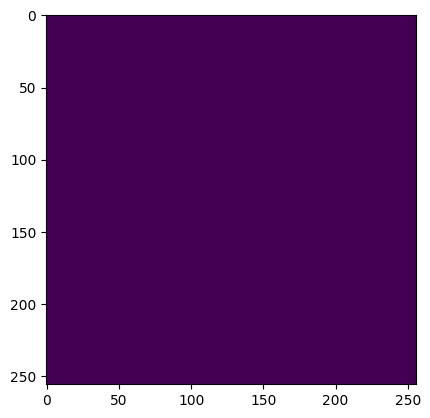

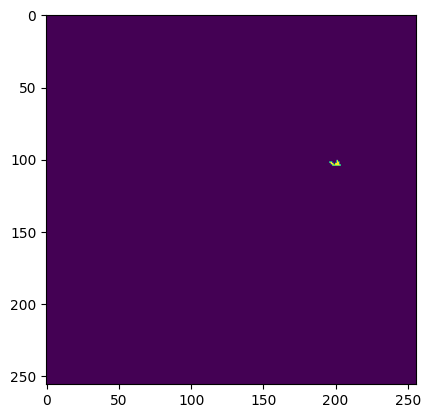

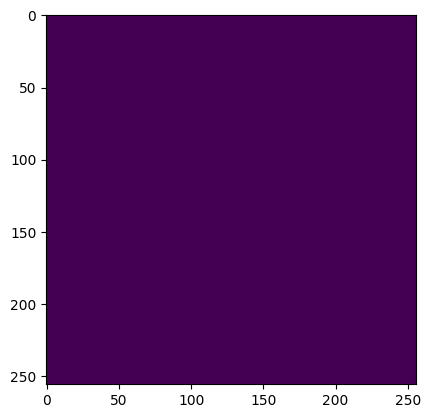

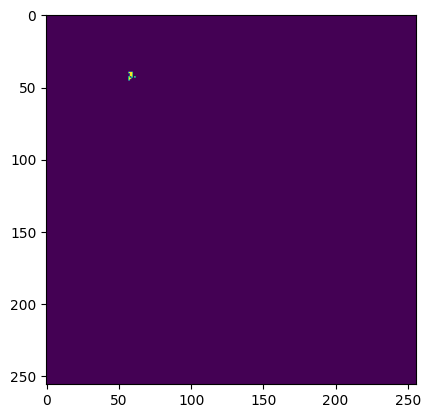

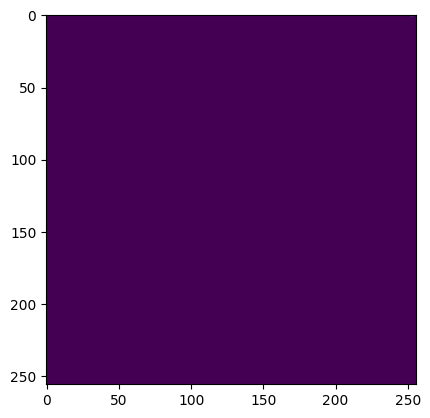

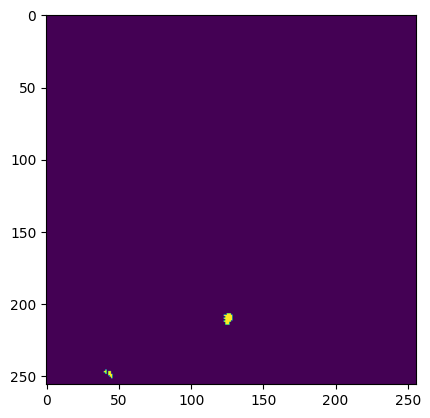

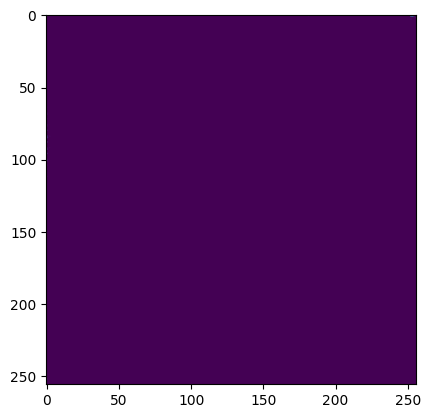

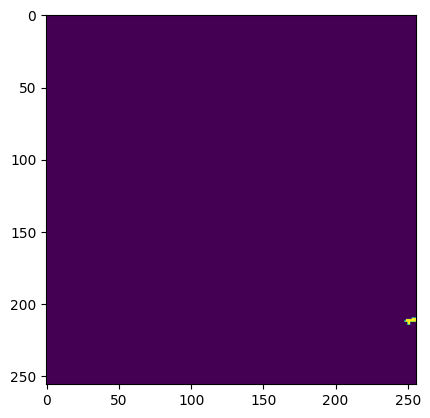

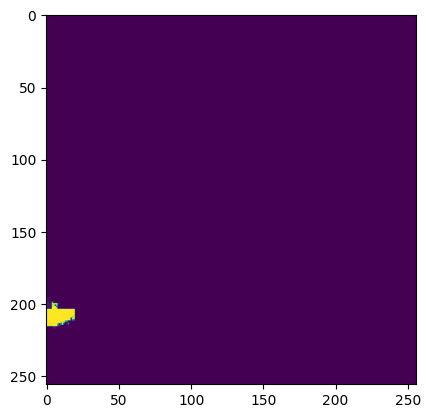

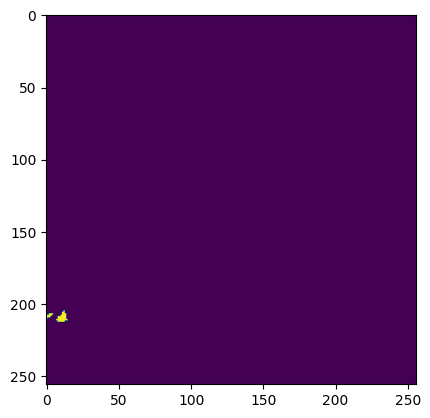

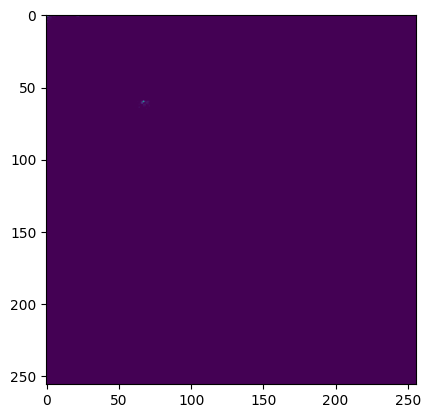

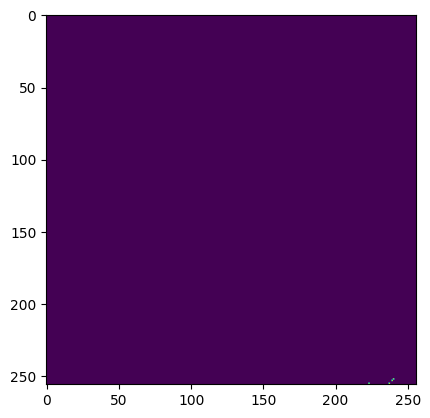

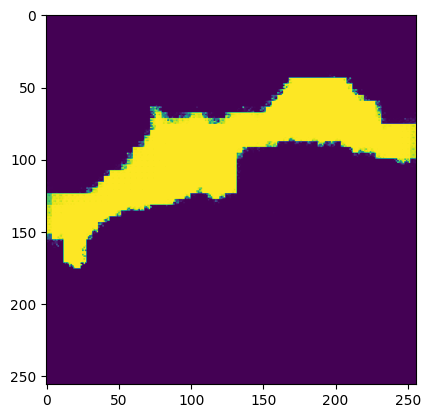

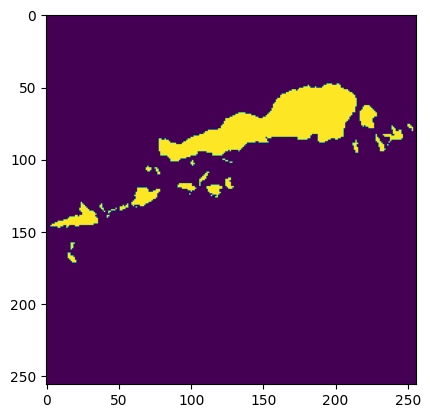

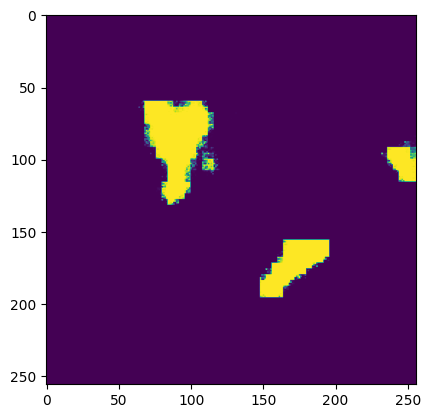

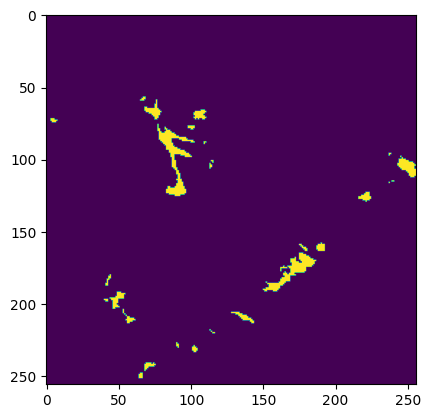

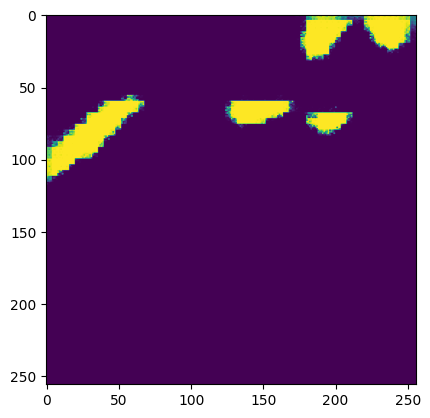

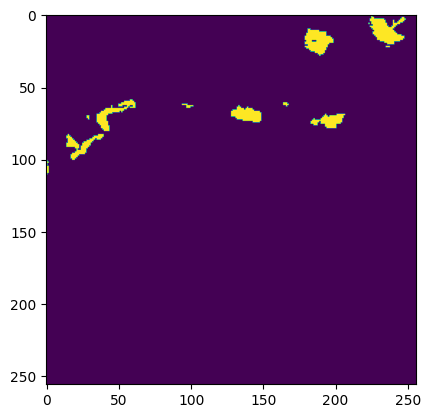

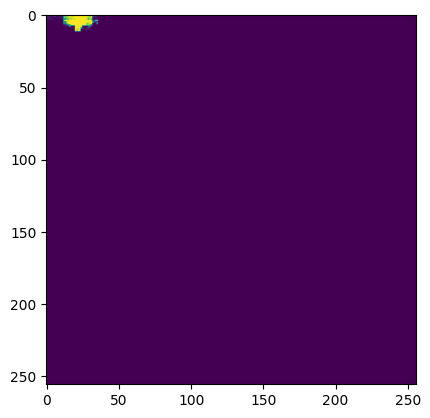

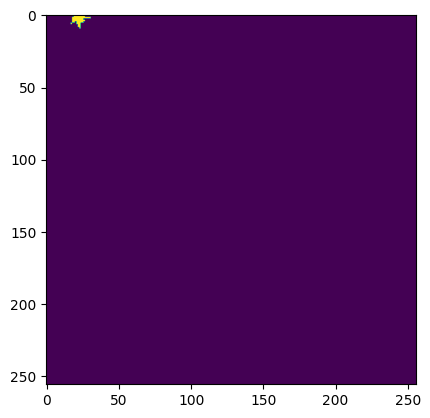

In [863]:
# Set the model to evaluation mode
model.eval()

for i in range(0,10):
    sample_embedding = torch.tensor(train_embs_with_polys['embeddings'].iloc[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]

    rasterio.plot.show(np.array(predicted_raster))
    rasterio.plot.show(train_raster_array[i])

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

#rasterio.plot.show(np.array(predicted_raster))

87
109
32


<Axes: >

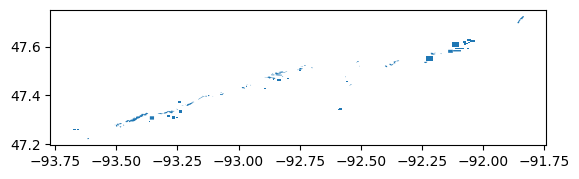

In [730]:
# Get polygons for bboxs with polygons, use bboxs for remaining
print(len(mn_qa_pits))
mn_qa_polys = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how = 'intersection')

bboxs_with_polygon = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how="left", predicate="intersects")
print(len(bboxs_with_polygon))

bboxs_without_polygon = bboxs_with_polygon[bboxs_with_polygon.index_right.isna()]
print(len(bboxs_without_polygon))

mn_qa_polys = pd.concat([mn_qa_polys, bboxs_without_polygon])

mn_qa_polys.plot()

#### NDWI labeling

In [7]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()
    print(len(all_items))

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")
    return items, dates

# Extract all band names from the items
#all_band_names = list(items[0].assets.keys()) 

In [8]:
aoi = {"type":"Polygon","coordinates":[[[-94.12454092629098,46.54458133806327],[-94.12454092629098,46.31198879756866],[-93.65835678372116,46.31198879756866],[-93.65835678372116,46.54458133806327],[-94.12454092629098,46.54458133806327]]]}

# Date range
start = "2024-01-01"
end = "2024-12-31"

In [9]:
# Separate into seasonal
q1stack, q1dates = SearchSTAC(aoi,"2024-01-01", "2024-03-31")
q2stack, q2dates = SearchSTAC(aoi,"2024-04-01", "2024-06-30")
q3stack, q3dates = SearchSTAC(aoi,"2024-07-01", "2024-09-30")
q4stack, q4dates = SearchSTAC(aoi,"2024-10-01", "2024-12-31")

3
Found 3 items
7
Found 7 items
9
Found 9 items
4
Found 3 items


In [10]:
# Retrieve the pixel values, for the bounding box in
# the target projection.

def RetrievePixels(items):
    dask.config.set({"array.slicing.split_large_chunks": True})

    epsg = items[0].properties["proj:epsg"]
    gsd = 40

    stack = stackstac.stack(
        items,
        snap_bounds=False,
        epsg=epsg,
        resolution=gsd,
        dtype="float32",
        rescale=False,
        fill_value=np.float32(0),
        assets=["green", "nir"],
        resampling=Resampling.nearest,
        chunksize=1024
    )
    print(stack)

    stack = stack.compute()
    return stack


In [11]:
stack1 = RetrievePixels(q1stack)
stack2 = RetrievePixels(q2stack)
stack3 = RetrievePixels(q3stack)
stack4 = RetrievePixels(q4stack)

<xarray.DataArray 'stackstac-f2d9b4cb8c242447647e268ed1362413' (time: 3,
                                                                band: 2,
                                                                y: 2745, x: 2745)> Size: 181MB
dask.array<fetch_raster_window, shape=(3, 2, 2745, 2745), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 24B 2024-0...
    id                                       (time) <U24 288B 'S2B_15TVM_2024...
  * band                                     (band) <U5 40B 'green' 'nir'
  * x                                        (x) float64 22kB 4e+05 ... 5.097...
  * y                                        (y) float64 22kB 5.2e+06 ... 5.0...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:shape                               object 8B {10980}
    raster:bands                        

In [12]:
# Get median of values across time for different bands for each season
import xarray as xr

q1_composite = stack1.groupby('band').median(dim = 'time')
q2_composite = stack2.groupby('band').median(dim = 'time')
q3_composite = stack3.groupby('band').median(dim = 'time')
q4_composite = stack4.groupby('band').median(dim = 'time')

# Calculate NDWI and create water mask 
def CalculateNDWI(image):
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

ndwi_q1 = CalculateNDWI(q1_composite)
ndwi_q2 = CalculateNDWI(q2_composite)
ndwi_q3 = CalculateNDWI(q3_composite)
ndwi_q4 = CalculateNDWI(q4_composite)

ndwi_ds = [ndwi_q1, ndwi_q2, ndwi_q3, ndwi_q4]

for i in range(len(ndwi_ds)):
    if 's2:processing_baseline' in ndwi_ds[i].coords:
        ndwi_ds[i] = ndwi_ds[i].reset_coords('s2:processing_baseline', drop=True)
        
annual_median = xr.concat(ndwi_ds, dim="time").median(dim='time')


In [13]:
import rioxarray as rxr

# Get water mask, get intersection with pit lakes as positive
# Reproject  
water_mask = annual_median.rio.write_crs('epsg:32615', inplace=True)
water_mask = water_mask.rio.reproject('epsg:4326')
water_mask = xr.where(water_mask > 0.1, 1, 0)

In [14]:
water_mask

<xarray.DataArray 'stackstac-f2d9b4cb8c242447647e268ed1362413' (y: 2218, x: 3214)> Size: 29MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates: (12/25)
  * x                                        (x) float64 26kB -94.31 ... -92.87
  * y                                        (y) float64 18kB 46.95 ... 45.96
    instruments                              <U3 12B 'msi'
    mgrs:grid_square                         <U2 8B 'VM'
    platform                                 <U11 44B 'sentinel-2b'
    gsd                                      int32 4B 10
    ...                                       ...
    s2:saturated_defective_pixel_percentage  int32 4B 0
    s2:sequence                              <U1 4B '0'
    constellation                            <U10 40B 'sentinel-2'
    processing:software                      object 8B {'sentinel2-to-stac': ...
    s2:degraded_msi_data_percentage          int32 4B 0
    spatial_ref                              int32 4B 0

Label water

In [745]:
from rasterstats import zonal_stats

'The primary zonal statistics entry point.\n\n    All arguments are passed directly to ``gen_zonal_stats``.\n    See its docstring for details.\n\n    The only difference is that ``zonal_stats`` will\n    return a list rather than a generator.'

In [760]:
# Re-label bounding boxes with water mask

# Perform zonal statistics for each vector feature
water_mask_chips = zonal_stats(mn_qa_bboxs, water_mask)

# Add the statistics to the vector data
testing = mn_qa_bboxs.join(pd.DataFrame(water_mask_chips))
testing.columns

with rasterio.open('path_to_raster.tif') as src:
    affine = src.affine
    array = src.read(1)
#mn_data = mn_data.join(pd.DataFrame(water_mask_chips))

# If NDWI indicates water, label as positive. Else, negative

TypeError: invalid path or file: <xarray.DataArray 'stackstac-f2d9b4cb8c242447647e268ed1362413' (y: 2745, x: 2745)> Size: 30MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates: (12/25)
  * x                                        (x) float64 22kB 4e+05 ... 5.097...
  * y                                        (y) float64 22kB 5.2e+06 ... 5.0...
    grid:code                                <U10 40B 'MGRS-15TVM'
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'T'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    proj:transform                           object 8B {0, 10, 5200020, -10, ...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    epsg                                     int32 4B 32615
    s2:snow_ice_percentage                   int32 4B 0
    s2:degraded_msi_data_percentage          int32 4B 0
    spatial_ref                              int32 4B 0

In [25]:
# Get chips with pit lakes and regular bodies of water in MN from QA
mn_data = LabelEmbeddings(mine_embeddings_mn, lake_embeddings_mn, mn_qa_polys, dnr_water_cropped)
print(f"Total samples: {len(mn_data)}") 


# Get chips for features identified as not lakes from QA
mn_nonlakes_chips = LabelEmbeddings(dummy, qa_non_mine_embeddings_mn, gpd.GeoDataFrame(), mn_qa_nonlakes)
print(f"Total samples: {len(mn_nonlakes_chips)}") 

mn_data = pd.concat([mn_data,mn_nonlakes_chips], ignore_index=True) # Add lakes to MN embeddings

Number of positive samples:
4317
Total samples: 28841
Number of positive samples:
0
Total samples: 2592


### PCA and tSNE

In [63]:
# Define function to get principle components and plot with data for each embedding

def EmbeddingsPCA(data, column = 'embeddings'):
    """
    
    Parameters: 
    data (GeoDataFrame):
    column (str): column of data with variable

    """
    # Convert embeddings to array and do PCA
    X =  np.vstack(data[column].values)
    pca = PCA(n_components=1)
    pca.fit(X)

    # Check on variance explained by given # of dimensions of PCA
    print("Relative variance in principal components:", pca.explained_variance_ratio_)

    # Apply PCA to get first two dimensions
    data['pca1'] = pca.transform(X)[:, 0]
    #data['pca2'] = pca.transform(X)[:, 1]

    return data

In [65]:
def PCAVisualization(data, column, label1, label2):
    # Visualize the first two principal components with category color-coding
    fig, ax = plt.subplots()

    # Plot for category 1
    ax.scatter(data[data[column] == True]['pca1'], 
                data[data[column] == True]['pca2'], 
                color='blue', label=label1, alpha=0.5)

    # Plot for category 2
    ax.scatter(data[data[column] == False]['pca1'], 
                data[data[column] == False]['pca2'], 
                color='grey', label=label2, alpha=0.05)
    
    """ EDIT SO CAN SEE WHAT THE LITTLE OVERLAP IS  plt.scatter(data[data['wb_'] == new_condition]['pca1'], 
            data[data[new_class_column] == new_condition]['pca2'], 
            color='red', label=label3, alpha=0.5, marker='^') """

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    ax.legend()
    plt.title('PCA of NAIP Embeddings')

    return ax

Relative variance in principal components: [0.20246004 0.11758959 0.09478324]


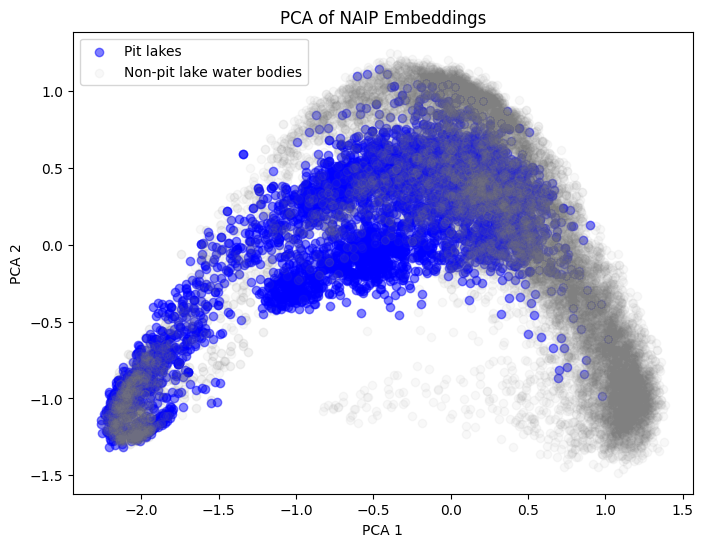

In [128]:
mn_pca = EmbeddingsPCA(mn_data)
PCAVisualization(mn_pca, column = 'mine', label1 = 'Pit lakes', label2 = 'Non-pit lake water bodies')

Relative variance in principal components: [0.19072938 0.11326633 0.09525669]


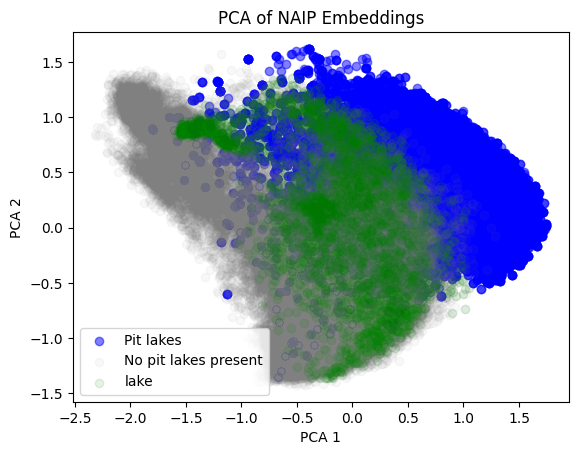

In [203]:
az_pca = EmbeddingsPCA(az_data)
ax = PCAVisualization(az_pca, 'mine','Pit lakes', 'No pit lakes present')

end_idx = len(az_pca)-1
start_idx = end_idx-len(az_lakes_chips)

ax.scatter(az_pca[start_idx:end_idx]['pca1'], 
                az_pca[start_idx:end_idx]['pca2'],
                color='green', label = 'lake', alpha = 0.1)

ax.legend()
plt.show()

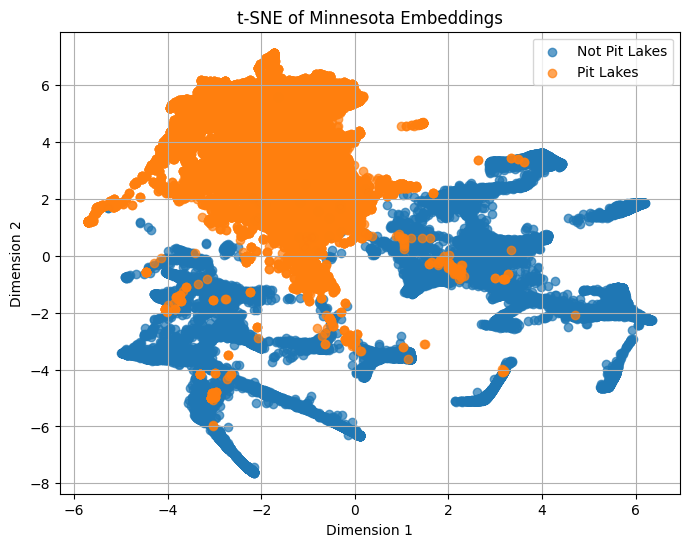

In [ ]:
#t-SNE of positive/negative embeddings

labels = data['mine'].values

tsne_data = np.vstack(data['embeddings'].values)

# Set up t-SNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=250)
reduced_embeddings = tsne.fit_transform(tsne_data)

# Visualize the results
plt.figure(figsize=(8, 6))

custom_labels = {0: "Not Pit Lakes", 1: "Pit Lakes"}

for label in np.unique(labels):
    mask = labels == label
    plt.scatter(reduced_embeddings[mask, 1],
                reduced_embeddings[mask, 0],
                label=custom_labels.get(label, f"Label {label}"),
                alpha=0.7)

plt.title("t-SNE of Minnesota Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

### Build classification model to predict presence of pit lakes

In [133]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection')
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data
    intersecting['area_overlap'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['area_overlap'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['area_overlap'] / row.geometry.area
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['area_overlap']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

Minnesota & Indiana

In [1159]:
# Get MN, IN, KY data
in_mn_data = pd.concat([in_data, mn_data])
north_data = pd.concat([in_mn_data, ky_data])
in_mn_pits = pd.concat([mn_aggregated_pits, in_qa_pits])
north_pits = pd.concat([in_mn_pits, ky_qa_pits])

# Check if intersection of each chip with a pit lake polygon is > 0.5%
in_mn_data_marked = MarkSamples(north_data, north_pits, 0.006)
print((in_mn_data_marked['mine']==1).sum())
print(len(in_mn_data_marked))

# Split into train and test
in_mn_data_marked_reset = in_mn_data_marked.reset_index(drop=True)
in_mn_train_embeddings = np.vstack(in_mn_data_marked_reset['embeddings'].values)
in_mn_labels = np.array(in_mn_data_marked_reset['mine'])
in_mn_indices = in_mn_data_marked_reset.index

in_mn_X_train, in_mn_X_test, in_mn_y_train, in_mn_y_test, in_mn_train_idx, in_mn_test_idx = sklearn.model_selection.train_test_split(in_mn_train_embeddings, in_mn_labels, in_mn_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(in_mn_X_train))
print(np.shape(in_mn_X_test))
print(np.shape(in_mn_y_train))
print(np.shape(in_mn_y_test))

73
284
(213, 1024)
(71, 1024)
(213,)
(71,)


In [1157]:
# Train neural network model for IN and MN
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=mn_y_train)

# Convert the class weights to a dictionary
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

in_mn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 1000, 
                    random_state=1)

in_mn_clf.fit(in_mn_X_train, in_mn_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=1000,
              random_state=1, solver='lbfgs')

In [1167]:
# Run predictions on test set and get F1 scores and probabilities

in_mn_predictions = in_mn_clf.predict(in_mn_X_test) 
print(f'Number of positive predictions: {in_mn_predictions.sum()}')
print(f'Number of positive samples: {in_mn_y_test.sum()}')
print(f'Number of test samples: {len(in_mn_X_test)}')

f1 = sklearn.metrics.f1_score(in_mn_y_test, in_mn_predictions)
print(f'F1: {f1}')

in_mn_precision = sklearn.metrics.precision_score(in_mn_y_test, in_mn_predictions)
print(f'precision: {in_mn_precision}')

in_mn_recall = sklearn.metrics.recall_score(in_mn_y_test, in_mn_predictions)
print(f'recall: {in_mn_recall}')

in_mn_probabilities = in_mn_clf.predict_proba(in_mn_X_test)
print(f'Classes for probability: {in_mn_clf.classes_}')

in_mn_probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 17
Number of positive samples: 10
Number of test samples: 71
F1: 0.6666666666666666
precision: 0.5294117647058824
recall: 0.9
Classes for probability: [0 1]


array([8.05888043e-217, 2.94808214e-216, 4.53281603e-072, 7.87145416e-126,
       0.00000000e+000, 1.00000000e+000, 3.19583473e-135, 1.00000000e+000,
       1.38712262e-171, 0.00000000e+000, 0.00000000e+000, 1.50086835e-022,
       0.00000000e+000, 1.00000000e+000, 7.31327158e-029, 0.00000000e+000,
       6.02577278e-130, 1.00000000e+000, 1.29094781e-104, 1.91613475e-197,
       1.91062182e-020, 4.67386347e-087, 0.00000000e+000, 7.63321020e-134,
       6.88392065e-272, 1.44228133e-153, 1.00357201e-149, 0.00000000e+000,
       1.86504036e-188, 9.99942248e-001, 1.10683529e-092, 1.12686605e-024,
       5.00271909e-001, 5.86714004e-008, 1.29087522e-066, 1.51878320e-153,
       5.89104594e-091, 1.00000000e+000, 1.00000000e+000, 7.45965083e-147,
       4.41728759e-025, 4.63402464e-218, 1.17766616e-106, 1.20544534e-166,
       0.00000000e+000, 1.00000000e+000, 3.17997317e-087, 4.98721524e-001,
       1.09788919e-253, 1.40279180e-130, 1.00000000e+000, 9.99998798e-001,
       4.39473694e-234, 2

In [1161]:
# Write predictions and probabilities to shapefiles
in_mn_pits_geom = in_mn_data_marked_reset.loc[in_mn_test_idx].geometry.reset_index(drop = True)

in_mn_pits_pred = gpd.GeoDataFrame(in_mn_predictions, columns = ['mines'], geometry=in_mn_pits_geom, crs = 'EPSG:4326')
in_mn_pits_probs = gpd.GeoDataFrame(in_mn_probabilities[:,1], columns = ['mine_prob'], geometry=in_mn_pits_geom, crs = 'EPSG:4326')

in_mn_pits_probs.to_file('north_pits_probs_0112')

In [1168]:
import joblib
joblib.dump(in_mn_clf, 'data/NorthPitLakeClf0112.pkl')

['data/NorthPitLakeClf0112.pkl']

#### Minnesota

In [979]:
# Check if intersection of each chip with a pit lake polygon is > 0.5%
mn_data_marked = MarkSamples(mn_data, mn_aggregated_pits, 0.005)
print((mn_data_marked['mine']==1).sum())
print(len(mn_data_marked))


17
199


In [975]:
mn_data_marked.to_file('mn_coverage_check_112')

PermissionError: [WinError 5] Access is denied: 'mn_coverage_check_112'

In [980]:
# Split into train and test for MN

mn_data_marked_reset = mn_data_marked.reset_index(drop=True)
mn_train_embeddings = np.vstack(mn_data_marked_reset['embeddings'].values)
mn_labels = np.array(mn_data_marked_reset['mine'])
mn_indices = mn_data_marked_reset.index

mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = sklearn.model_selection.train_test_split(mn_train_embeddings, mn_labels, mn_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(mn_X_train))
print(np.shape(mn_X_test))
print(np.shape(mn_y_train))
print(np.shape(mn_y_test))

(149, 1024)
(50, 1024)
(149,)
(50,)


In [981]:
# Train neural network model
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=mn_y_train)

# Convert the class weights to a dictionary
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

mn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(32, 32, 32), max_iter = 1000, 
                    random_state=1)

mn_clf.fit(mn_X_train, mn_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(32, 32, 32), max_iter=1000,
              random_state=1, solver='lbfgs')

In [982]:
# Run predictions on test set and get F1 scores and probabilities

mn_predictions = mn_clf.predict(mn_X_test) 
print(f'Number of positive predictions: {mn_predictions.sum()}')
print(f'Number of positive samples: {mn_y_test.sum()}')
print(f'Number of test samples: {len(mn_X_test)}')

f1 = sklearn.metrics.f1_score(mn_y_test, mn_predictions)
print(f'F1: {f1}')

mn_precision = sklearn.metrics.precision_score(mn_y_test, mn_predictions)
print(f'precision: {mn_precision}')

mn_probabilities = mn_clf.predict_proba(mn_X_test)
print(f'Classes for probability: {mn_clf.classes_}')

mn_probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 2
Number of positive samples: 4
Number of test samples: 50
F1: 0.3333333333333333
precision: 0.5
Classes for probability: [0 1]


array([1.02009359e-28, 5.03049654e-28, 7.97883660e-20, 3.35324498e-39,
       1.56373802e-31, 6.72526301e-08, 2.18372357e-38, 1.99079583e-31,
       3.15851236e-05, 1.03675848e-21, 1.62368943e-29, 1.76737073e-37,
       3.44555294e-39, 8.71180028e-36, 6.69626196e-37, 7.97883660e-20,
       5.61224957e-31, 5.54907309e-37, 1.44059856e-06, 2.71919827e-30,
       1.67027218e-28, 1.34087444e-42, 1.01239331e-28, 3.89998394e-38,
       6.74411898e-24, 2.32040096e-35, 7.75291951e-36, 2.34880048e-43,
       1.10558750e-29, 1.04282763e-22, 2.50092666e-36, 3.95125575e-38,
       2.69146350e-20, 1.15367044e-36, 9.99953708e-01, 2.00015036e-36,
       4.48396169e-13, 1.04057098e-34, 1.16799767e-36, 3.35894048e-13,
       1.85717507e-31, 2.71919827e-30, 1.00000000e+00, 7.66341445e-41,
       2.81632049e-07, 7.80475687e-37, 3.97393787e-40, 2.41560560e-17,
       1.61266950e-36, 3.73356550e-34])

In [166]:
import joblib
joblib.dump(mn_clf, 'data/MNPitLakeClf0109.pkl')

['data/MNPitLakeClf0109.pkl']

In [966]:
# Write predictions and probabilities to shapefiles
mn_pits_geom = mn_data_marked_reset.loc[mn_test_idx].geometry.reset_index(drop = True)

mn_pits_pred = gpd.GeoDataFrame(mn_predictions, columns = ['mines'], geometry=mn_pits_geom, crs = 'EPSG:4326')
mn_pits_probs = gpd.GeoDataFrame(mn_probabilities[:,1], columns = ['mine_prob'], geometry=mn_pits_geom, crs = 'EPSG:4326')

mn_pits_probs.to_file('mn_pits_probs_0112')

F1 on training data: 0.8888888888888888
Accuracy on training data: 0.9731543624161074
Accuracy on test data: 0.9


<Axes: >

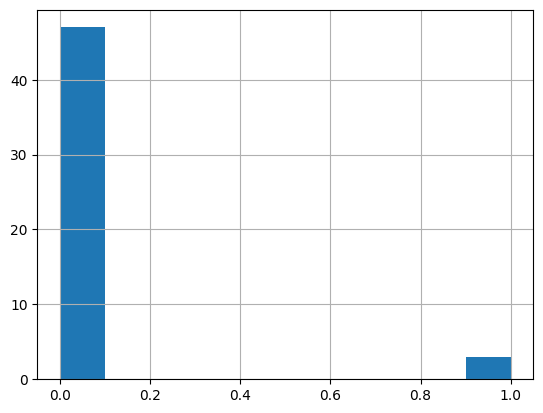

In [967]:
mn_train_predictions = mn_clf.predict(mn_X_train)

mn_f1_train = sklearn.metrics.f1_score(mn_y_train, mn_train_predictions)
print(f'F1 on training data: {mn_f1_train}')

mn_train_accuracy = sklearn.metrics.accuracy_score(mn_y_train, mn_train_predictions)
mn_test_accuracy = sklearn.metrics.accuracy_score(mn_y_test, mn_predictions)
print(f'Accuracy on training data: {mn_train_accuracy}')
print(f'Accuracy on test data: {mn_test_accuracy}')

# Plot histogram of probability predictions on test set
test_probs = pd.DataFrame(mn_probabilities)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
test_probs[1].hist(bins = bins)

Number of images:
38
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
2295
Number of positive samples:
15
Total samples:
15


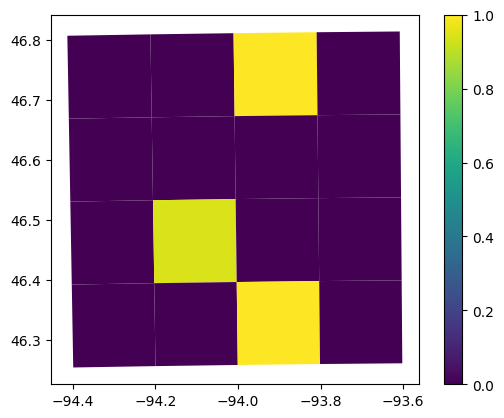

In [968]:
# Get embeddings for Crosby, MN
crosby_pitlakes = gpd.read_file('data/crosby_mn.geojson') # all Crosby

crosby_embeddings, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = crosby_pitlakes, random_images = False)

print("Number of images:")
print(len(crosby_embeddings))

# Get Crosby test chips
crosby_embeddings = pd.DataFrame(crosby_embeddings)
crosby_embs_avg = MonthlyComposite(crosby_embeddings)
print(len(crosby_embs_avg))
crosby_test_chips = LabelEmbeddings1_5(crosby_embs_avg, dummy, crosby_pitlakes) #  getting all Crosby, not just pit lakes

print("Total samples:") 
print(len(crosby_test_chips))

crosby_test = np.vstack(crosby_test_chips['embeddings'].values) 

crosby_test_preds = gpd.GeoDataFrame(mn_clf.predict(crosby_test), columns = ['mine'], geometry = crosby_test_chips['geometry'])
crosby_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(crosby_test)[:,1], columns = ['mine_prob'], geometry=crosby_test_chips['geometry'], crs = 'EPSG:4326')

crosby_test_probs.plot(column = 'mine_prob', legend = True)

# Write Crosby predictions to shapefile
crosby_test_probs.to_file('crosby_testing_0112')

<Axes: >

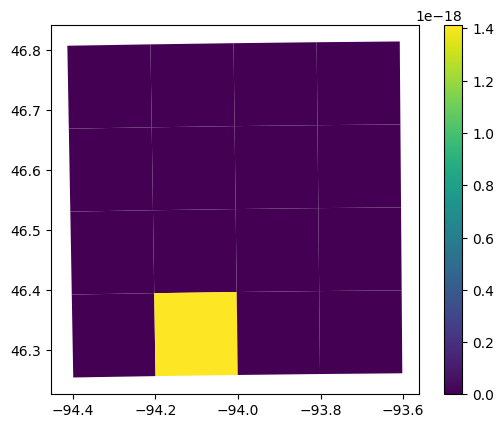

In [1171]:
# Test with IN and MN combined model

crosby_test_preds = gpd.GeoDataFrame(in_mn_clf.predict(crosby_test), columns = ['mine'], geometry = crosby_test_chips['geometry'])
crosby_test_probs = gpd.GeoDataFrame(in_mn_clf.predict_proba(crosby_test)[:,1], columns = ['mine_prob'], geometry=crosby_test_chips['geometry'], crs = 'EPSG:4326')

crosby_test_probs.plot(column = 'mine_prob', legend = True)

# Write Crosby predictions to shapefile
#crosby_test_probs.to_file('crosby_testing_0112_no')

In [1165]:
(crosby_test_preds['mine']==1).sum()

dnr_pit_lakes_crosby = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

crosby_pits = gpd.sjoin(dnr_pit_lakes_crosby, crosby_pitlakes, how='inner', predicate = 'intersects')

crosby_marked = MarkSamples(crosby_test_chips, crosby_pits, 0.002)

print(crosby_marked['mine'].sum())
len(crosby_test_probs)

2


15

In [131]:
# Get embeddings for MI
mi_qa = gpd.read_file('data/mi_testing.geojson')

mi_qa_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_qa, random_images = False)

print("Number of images:")
print(len(mi_qa_embeddings))

# Get MI test chips
mi_test_chips = LabelEmbeddings(mi_qa_embeddings, dummy, mi_qa)

print("Total samples:") 
print(len(mi_test_chips))

mi_test = np.vstack(mi_test_chips['embeddings'].values) 

mi_test_preds = gpd.GeoDataFrame(mn_clf.predict(mi_test), columns = ['mine'], geometry = mi_test_chips['geometry'])
mi_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(mi_test)[:,1], columns = ['mine_prob'], geometry=mi_test_chips['geometry'], crs = 'EPSG:4326')

# Write Crosby predictions to shapefile
mi_test_probs.to_file('mi_testing_1218')

NameError: name 'GetEmbeddingsFromIntersection' is not defined

#### Test on MI lakes vs. pit lakes

29
14


<Axes: >

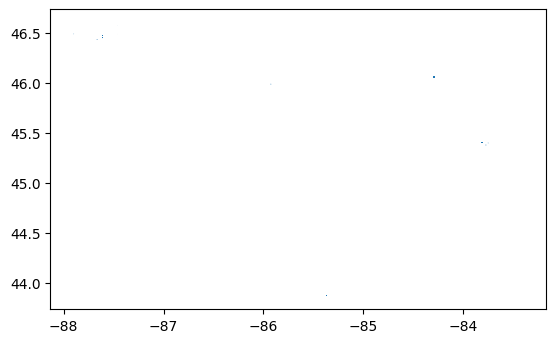

In [ ]:
# Get lake data - filter out pit lakes

mi_lakes = gpd.read_file('data/mi_Lake_Polygons.geojson').to_crs(epsg = 4326)
states = gpd.read_file('data/state_boundaries')
mi = states[states['STUSPS']=='MI']
mi = mi.to_crs(epsg = 4326).geometry.unary_union 
mi_qa = US_QA[US_QA.geometry.intersects(mi)]

mi_qa_pits = mi_qa[mi_qa['category'].isin(['a','q'])] # QAed pit lakes and questionable
mi_lakes_polys = gpd.overlay(mi_lakes, mi_qa_pits, how = 'difference')
print(len(mi_lakes_polys))

# Get pit lake polygon intersections - keep polygons within pit lakes; otherwise keep bbox
mi_qa_polys = gpd.overlay(mi_qa_pits, mi_lakes, how = 'intersection')

bboxs_with_polygon = gpd.sjoin(mi_qa_pits, mi_lakes, how="left", predicate="intersects")
print(len(bboxs_with_polygon))

bboxs_without_polygon = bboxs_with_polygon[bboxs_with_polygon.index_right.isna()]
print(len(bboxs_without_polygon))

mi_qa_polys = pd.concat([mi_qa_polys, bboxs_without_polygon])
mi_qa_polys.plot()

In [ ]:
# Get intersecting embeddings, label these
mi_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_qa_polys, random_images = False)

print("Number of mine images:")
print(len(mi_embeddings))

# Crop
random_idx = random.sample(range(1, len(mi_lakes_polys)), 500)
mi_lakes_cropped = mi_lakes_polys.iloc[random_idx]

Number of mine images:
19
Number of water images: 19
Number of positive samples:
872
Total samples:
872


TypeError: '<' not supported between instances of 'Polygon' and 'int'

In [52]:
# Get lake intersecting embeddings
mi_water_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_lakes_cropped, random_images = False)
print(f"Number of water images: {len(mi_embeddings)}")

# Get MI test chips
mi_test_chips = LabelEmbeddings(mi_embeddings, mi_water_embeddings, mi_qa_polys, mi_lakes_cropped)

print("Total samples:") 
print(len(mi_test_chips))


# Predict on these
mi_test = np.vstack(mi_test_chips['embeddings'].values) 
mi_test_labels = mi_test_chips['mine']

mi_test_preds = gpd.GeoDataFrame(mn_clf.predict(mi_test), columns = ['mine'], geometry = mi_test_chips['geometry'])
mi_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(mi_test)[:,1], columns = ['mine_prob'], geometry=mi_test_chips['geometry'], crs = 'EPSG:4326')


Number of water images: 19
Number of positive samples:
872
Total samples:
5098


In [53]:
mi_test_preds_list = mn_clf.predict(mi_test)

mi_precision = sklearn.metrics.precision_score(mi_test_labels, mi_test_preds_list)
print(f'precision: {mi_precision}')

mi_f1 = sklearn.metrics.f1_score(mi_test_labels, mi_test_preds_list)
print(f'F1 on MI: {mi_f1}')

precision: 0.5163551401869159
F1 on MI: 0.34


In [54]:
# Write MI predictions to shapefile
mi_test_probs.to_file('mi_testing_1219_2p')


#### Arizona

In [681]:
# Mark as positive if intersection > 30% 
az_data_marked_reset = az_data.reset_index(drop=True)
az_data_marked = MarkSamples(az_data_marked_reset, az_qa_pits, 0.003)

print((az_data_marked['mine']==1).sum())

9


In [682]:
# Split into train and test for AZ

az_train_embeddings =  np.vstack(az_data_marked['embeddings'].values)
az_labels = np.array(az_data_marked['mine'])
az_indices = az_data_marked.index

az_X_train, az_X_test, az_y_train, az_y_test, az_train_idx, az_test_idx = sklearn.model_selection.train_test_split(az_train_embeddings, az_labels, az_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(az_X_train))
print(np.shape(az_X_test))
print(np.shape(az_y_train))
print(np.shape(az_y_test))

(33, 1024)
(11, 1024)
(33,)
(11,)


In [683]:
# Train neural network model

az_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 1000, random_state=1)

az_clf.fit(az_X_train, az_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=1000,
              random_state=1, solver='lbfgs')

In [684]:
az_predictions = az_clf.predict(az_X_test) 
print(f'Number of positive predictions: {az_predictions.sum()}')
print(f'Number of test samples: {len(az_X_test)}')

az_f1 = sklearn.metrics.f1_score(az_y_test, az_predictions)
print(f'F1: {f1}')

probabilities = az_clf.predict_proba(az_X_test)
print(f'Classes for probability: {az_clf.classes_}')

probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 0
Number of test samples: 11
F1: 0.4
Classes for probability: [0 1]


array([3.19449397e-075, 9.50345921e-021, 4.98229664e-069, 6.92748241e-011,
       8.26009032e-030, 6.35494906e-024, 3.35234941e-080, 7.34486729e-049,
       6.65294129e-016, 4.10331346e-101, 4.72361086e-032])

F1 on training data: 0.36666666666666664
Accuracy on training data: 0.9054726368159204
Accuracy on test data: 0.9029850746268657


<Axes: >

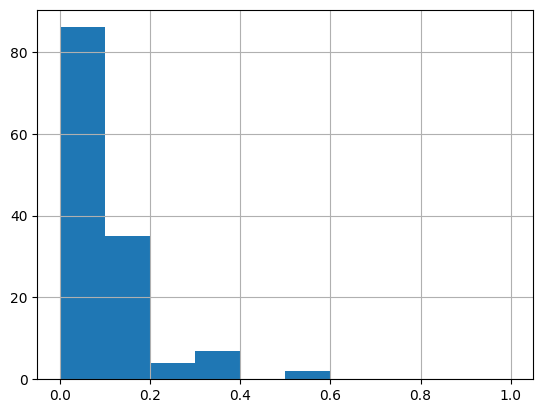

In [125]:
az_train_predictions = az_clf.predict(az_X_train)

az_f1_train = sklearn.metrics.f1_score(az_y_train, az_train_predictions)
print(f'F1 on training data: {az_f1_train}')

train_accuracy = sklearn.metrics.accuracy_score(az_y_train, az_train_predictions)
test_accuracy = sklearn.metrics.accuracy_score(az_y_test, az_predictions)
print(f'Accuracy on training data: {train_accuracy}')
print(f'Accuracy on test data: {test_accuracy}')

# Plot histogram of probability predictions on test set
test_probs = pd.DataFrame(probabilities)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
test_probs[1].hist(bins = bins)

In [126]:
# Write predictions and probabilities to shapefiles
az_pits_geom = az_data.geometry.loc[az_test_idx].reset_index(drop = True)
az_pits_pred = gpd.GeoDataFrame(az_predictions, columns = ['mines'], geometry=az_pits_geom, crs = 'EPSG:4326')
az_pits_probs = gpd.GeoDataFrame(probabilities[:,1], columns = ['mine_prob'], geometry=az_pits_geom, crs = 'EPSG:4326')

#az_pits_pred.to_file('az_pits_pred_1')
az_pits_probs.to_file('az_pits_probs_0108')

KeyError: '[512, 529, 524, 500, 526, 503, 530] not in index'

In [ ]:
# Get embeddings for Miami, AZ pitlakes
miami_pitlakes = gpd.read_file('data/miami_az_pits.geojson')

miami_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_az/rgbir_cog/', polygons = miami_pitlakes, random_images = False)

print("Number of images:")
print(len(miami_embeddings))

# Get test chips in AZ
miami_test_chips = LabelEmbeddings(miami_embeddings, dummy, miami_pitlakes)

print("Total samples:") 
print(len(miami_test_chips))

miami_test = np.vstack(miami_test_chips['embeddings'].values) 

miami_test_preds = gpd.GeoDataFrame(az_clf.predict(miami_test), columns = ['mine'], geometry = miami_test_chips['geometry'])
miami_test_probs = gpd.GeoDataFrame(az_clf.predict_proba(miami_test)[:,1], columns = ['mine_prob'], geometry=miami_test_chips['geometry'], crs = 'EPSG:4326')

miami_test_probs.to_file('miami_az_testing_heldout_1216')
miami_test_probs

Random images: 0
Number of images:
12
Number of positive samples:
10836
Total samples:
10836


,mine_prob,geometry
0,1.000000e+00,"POLYGON ((-110.93859 33.46812, -110.9386 33.46..."
1,1.000000e+00,"POLYGON ((-110.93694 33.46812, -110.93694 33.4..."
2,1.000000e+00,"POLYGON ((-110.93529 33.46812, -110.93529 33.4..."
3,9.999144e-01,"POLYGON ((-110.93363 33.46812, -110.93364 33.4..."
4,1.000000e+00,"POLYGON ((-110.93198 33.46811, -110.93198 33.4..."
...,...,...
10831,8.016509e-13,"POLYGON ((-111.00417 33.36248, -111.00417 33.3..."
10832,2.837483e-04,"POLYGON ((-111.00252 33.36248, -111.00252 33.3..."
10833,9.337610e-01,"POLYGON ((-111.00087 33.36248, -111.00087 33.3..."
10834,9.989062e-01,"POLYGON ((-110.99922 33.36248, -110.99922 33.3..."


In [118]:
az_mines_intersect.to_file('mines_polys')

### REST OF NOTEBOOK IN DRAFT

#### Visualize a few mines

In [14]:
# Point over mine in Hibbing, Minnesota

lat, lon = 47.362228, -93.046666

# AOI around pt
""" aoi_as_list = [[-87.09601677899997,39.685325944000056],
      [-87.19601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056],
      [-87.09601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056]] """

""" aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
} """

# Date range
start = "2021-01-01"
end = "2021-12-31"

In [16]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-3, lat - 1e-3, lon + 1e-3, lat + 1e-3),
    max_items=1,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


In [ ]:
# Retrieve the items
assets = []
assets_urls = []
item_latlons = []
item_bboxs = []

# Show 'visual' asset for true-color composite and create list of images
for item in items:
    asset = item.assets["visual"]
    assets.append(asset)
    assets_urls.append(asset.href)
    print(item.datetime)
    # Get centroids of images and create buffer polygons
    image_geom = Polygon(item.geometry['coordinates'][0])
    item_latlons.append(gpd.GeoDataFrame(geometry = [image_geom]).centroid)

for item in item_latlons:
    item_bboxs.append(item.buffer(0.2))
    print(item_bboxs)


2021-11-20 17:20:34.917000+00:00
[0    POLYGON ((-93.39776 47.35737, -93.39872 47.337...
dtype: geometry]


In [39]:
help(items[0])

Help on Item in module pystac.item object:

class Item(pystac.stac_object.STACObject, pystac.asset.Assets)
 |  Item(id: 'str', geometry: 'dict[str, Any] | None', bbox: 'list[float] | None', datetime: 'Datetime | None', properties: 'dict[str, Any]', start_datetime: 'Datetime | None' = None, end_datetime: 'Datetime | None' = None, stac_extensions: 'list[str] | None' = None, href: 'str | None' = None, collection: 'str | Collection | None' = None, extra_fields: 'dict[str, Any] | None' = None, assets: 'dict[str, Asset] | None' = None)
 |
 |  An Item is the core granular entity in a STAC, containing the core metadata
 |  that enables any client to search or crawl online catalogs of spatial 'assets' -
 |  satellite imagery, derived data, DEM's, etc.
 |
 |  Args:
 |      id : Provider identifier. Must be unique within the STAC.
 |      geometry : Defines the full footprint of the asset represented by this
 |          item, formatted according to
 |          `RFC 7946, section 3.1 (GeoJSON) <ht

In [35]:
item_bboxs_gpd = gpd.GeoDataFrame(geometry = item_bboxs[0],crs=4326)


In [ ]:
# Crop images - NEED TO FIX
from rasterio.mask import mask

with rasterio.open(assets_urls[0]) as src:
    cropped_image, cropped_transform = mask(src, item_bboxs_gpd[0].geometry, crop=True)

cropped_image_data = cropped_image 
cropped_image_transform = cropped_transform 

""" with rasterio.open("tests/data/RGB.byte.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta """

KeyError: 0

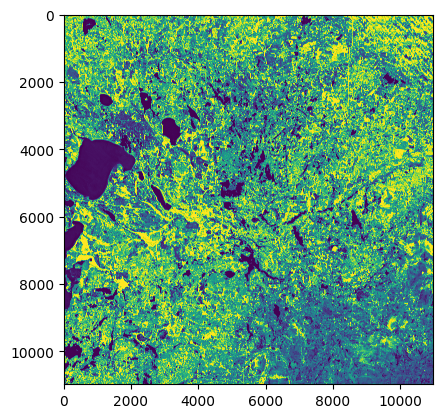

In [33]:
# Load and visualize the asset with rasterio

fig, ax = plt.subplots()

# Create image plotting function

src1 = rasterio.open(assets_urls[0])
#src2 = rasterio.open(assets_urls[1])
    
ax.imshow(src1.read(1))
#ax2.plt.imshow(src2.read(1))
plt.show()


### Find data for AOI
The first step is to find STAC items of imagery that we want to use to create embeddings. In this example we are going to use Earth Genome's composite dataset which comes with a great STAC catalog.

We are also going to create embeddings along time so that we have multiple embeddings for the same location at different moments in time.

In [ ]:
# Point over Nevada
# lat, lon = 39.145068721560506, -119.67465363188465

# AOI around Nevada
aoi_as_list = [[-119.1256714,39.6620962],
      [-119.1302491,39.5669496],
      [-118.959961,39.5500181],
      [-118.9544679,39.638862],
      [-119.1247559,39.6578851],
      [-119.1256714,39.6620962]]

aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
}

# Date range
start = "2018-07-01"
end = "2018-09-01"

In [32]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    intersects=aoi_as_dict, # CHANGED TO GET ONLY IMAGES INTERSECTING WITH AOI
    max_items=2,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


To speed up processing in this example, we limit the number of chips to 3 per Sentinel-2 scene. Remove this limit in a real use case.

In [ ]:
chips = []
datetimes = []
bboxs = []
chip_ids = []
item_ids = []

# Adjust desired chip dimension (pixels) 
# chip_dimension = int(224)
# stacchip.indexer.ChipIndexer.chip_size = chip_dimension # Edit default class chip size attribute
# Sentinel2Indexer.chip_size = chip_dimension

for item in items:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = Sentinel2Indexer(item)

    # Instanciate the chipper
    chipper = Chipper(indexer, assets=["red", "green", "blue", "nir", "scl"])

    # Get first chip for the "image" asset key
    for idx, (x, y, chip) in enumerate(chipper):
        #if idx > 3: # Remove this for full inference
        #    break
        del chip["scl"]
        chips.append(chip)
        datetimes.append(item.datetime)
        bboxs.append(indexer.get_chip_bbox(x, y))
        chip_ids.append((x, y))
        item_ids.append(item.id)

Working on <Item id=S2B_11SLD_20180825_1_L2A>


RasterioIOError: Read or write failed. /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LD/2018/8/S2B_11SLD_20180825_1_L2A/B04.tif, band 1: IReadBlock failed at X offset 2, Y offset 1: TIFFReadEncodedTile() failed.

In [149]:
# Drop chips that don't intersect and corresponding chips, datetimes, chip IDs, and item IDs

bboxs_gdf = gpd.GeoDataFrame(geometry=bboxs)
aoi = Polygon(aoi_as_list)

mask = bboxs_gdf.intersects(aoi) # Create mask of bboxs of chips that intersect the AOI

chips = pd.Series(chips)[mask].tolist()
datetimes = pd.Series(datetimes)[mask].tolist()
bboxs = pd.Series(bboxs)[mask].tolist()
chip_ids = pd.Series(chip_ids)[mask].tolist()
item_ids = pd.Series(item_ids)[mask].tolist()

print("Number of chips that intersect with AOI: ")
print(len(chips))

Number of chips that intersect with AOI: 
4


In [150]:
pixels = np.array([np.array(list(chip.values())).squeeze() for chip in chips])
pixels.shape

(4, 4, 256, 256)

In [1]:
#Visualize chips

gpd.GeoDataFrame(geometry = bboxs).plot()

NameError: name 'gpd' is not defined

Prepare band metadata for passing it to the model

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
# Retrieve the file content from the URL

url = (
    "https://raw.githubusercontent.com/Clay-foundation/model/main/configs/metadata.yaml"
)
response = requests.get(url, allow_redirects=True)

# Convert bytes to string
content = response.content.decode("utf-8")

# Load the yaml
content = yaml.safe_load(content)

metadata = Box(content)
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in chips[0].keys():
    mean.append(metadata[platform].bands.mean[band])
    std.append(metadata[platform].bands.std[band])
    waves.append(metadata[platform].bands.wavelength[band])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

Convert the band pixel data into the format for the model

In [ ]:
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding by normalizing centroids of chip bboxs
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = []

for bbox in bboxs:
    centroid = bbox.centroid
    lat, lon = centroid.y, centroid.x  # Extract lat, lon from centroid
    latlons.append(normalize_latlon(lat, lon))

#latlons = [normalize_latlon(lat, lon)] * len(times) # WHY DO WE WANT THE SAME THING REPEATED?
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Prep gsd
gsd = [10]

# Normalize pixels
pixels = transform(pixels)
pixels = pixels.astype(np.float32) # ADDED THIS BACK IN


In [ ]:
datacube = {
    "pixels": torch.tensor(pixels, dtype=torch.float32),
    "time": torch.tensor(np.hstack((week_norm, hour_norm)), dtype=torch.float32),
    "latlon": torch.tensor(np.hstack((lat_norm, lon_norm)), dtype=torch.float32),
    "waves": torch.tensor(waves, dtype=torch.float32),
    "gsd": torch.tensor(gsd, dtype=torch.float32),
}

In [ ]:
for k, v in datacube.items():
    print(k, v.shape)

pixels torch.Size([2, 4, 256, 256])
time torch.Size([2, 4])
latlon torch.Size([2, 4])
waves torch.Size([4])
gsd torch.Size([1])


### Clay Embedder

#### Load the embedder that is stored in ExportedProgram format using **cpu**.

#### Load and run the checkpoint of the model

In [36]:
import pytorch_lightning as pl
# Add LightningModule class inheritance to access load_from_checkpoint method
#class ClayMAE(pl.LightningModule): 
#    pass

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://huggingface.co/made-with-clay/Clay/resolve/main/clay_v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

RuntimeError: Unknown model (vit_large_patch14_reg4_dinov2)

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [139]:
# Run the clay encoder
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = clay_encoder(*datacube)
# Get class embeddings
cls_embedding = unmsk_patch[:, 0, :]
# Print shape of class embeddings
cls_embedding.shape

NameError: name 'clay_encoder' is not defined

#### Load and run the exported cpu model

In [ ]:
# Get file from local exportedprogram format

! wget -q https://huggingface.co/made-with-clay/Clay/blob/main/v1.5/compiled/clay-v1.5-encoder-cpu.pt2

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
ep_embedder_cpu = torch.export.load("data/clay-v1.5-encoder-cpu.pt2").module()

Run the model with EP

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: total: 11.8 s
Wall time: 9.1 s


(torch.Size([2, 4, 256, 256]), torch.Size([2, 768]))

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ExportedProgram format using **gpu**.

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder.pt2

In [ ]:
datacube = {k: v.to("cuda") for k, v in datacube.items()}
ep_embedder = torch.export.load("clay-v1-encoder.pt2").module()

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder(datacube)
datacube["pixels"].shape, embeddings.shape

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ONNX format using **cpu**.

In [ ]:
import onnxruntime as ort

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder-cpu.onnx

In [ ]:
datacube = {k: v.to("cpu") for k, v in datacube.items()}
onnx_embedder = ort.InferenceSession(
    "clay-v1-encoder-cpu.onnx", providers=["CPUExecutionProvider"]
)

In [ ]:
%%time
embeddings = onnx_embedder.run(
    [],
    {
        "cube": datacube["pixels"].numpy(),
        "time": datacube["time"].numpy(),
        "latlon": datacube["latlon"].numpy(),
        "waves": datacube["waves"].numpy(),
        "gsd": datacube["gsd"].numpy(),
    },
)[0]
embeddings.shape

For each chip, we have an embedding of size `768`

### Store the results

We create a table containing the embeddings, bounding box, the STAC item ID, the datetime of the image capture, and the chip x and y ids. Then we save that data to disk.

In [ ]:
# Write data to pyarrow table
index = {
    "datetimes": datetimes,
    "chip_ids": chip_ids,
    "item_ids": item_ids,
    "embeddings": [np.ascontiguousarray(dat) for dat in embeddings],
    "geometry": ga.as_geoarrow([dat.wkt for dat in bboxs]),
}
table = pa.table(index)
table

pyarrow.Table
datetimes: timestamp[us, tz=UTC]
chip_ids: list<item: int64>
  child 0, item: int64
item_ids: string
embeddings: list<item: float>
  child 0, item: float
geometry: extension<geoarrow.polygon<PolygonType>>
----
datetimes: [[2018-08-25 18:53:24.597000Z,2018-08-25 18:53:24.597000Z]]
chip_ids: [[[1,0],[2,0]]]
item_ids: [["S2B_11SLD_20180825_1_L2A","S2B_11SLD_20180825_1_L2A"]]
embeddings: [[[-0.12739897,0.06501336,-0.0043061064,0.093552634,0.15224756,...,0.048478447,-0.17023225,0.04420602,-0.18251786,-0.04366695],[-0.09462359,0.08339551,-0.030247303,0.114174575,0.17728658,...,0.044083178,-0.14688866,0.057765294,-0.17931639,-0.0330391]]]
geometry: [[[      -- is_valid: all not null
      -- child 0 type: double
[-118.9754053793589,-118.97146936387814,-119.15024167776343,-119.15453396559633,-118.9754053793589]
      -- child 1 type: double
[39.73345718524536,39.59514085820176,39.59196881845574,39.730269624751166,39.73345718524536]],[      -- is_valid: all not null
      -- child

In [ ]:
pq.write_table(table, "embeddings.parquet")

                         datetimes chip_ids                  item_ids  \
0 2018-08-25 18:53:24.597000+00:00   (1, 0)  S2B_11SLD_20180825_1_L2A   
1 2018-08-25 18:53:24.597000+00:00   (2, 0)  S2B_11SLD_20180825_1_L2A   

                                          embeddings  \
0  [-0.12739897, 0.06501336, -0.0043061064, 0.093...   
1  [-0.09462359, 0.08339551, -0.030247303, 0.1141...   

                                            geometry  
0  POLYGON ((-118.97541 39.73346, -118.97147 39.5...  
1  POLYGON ((-118.79625 39.73637, -118.79267 39.5...  


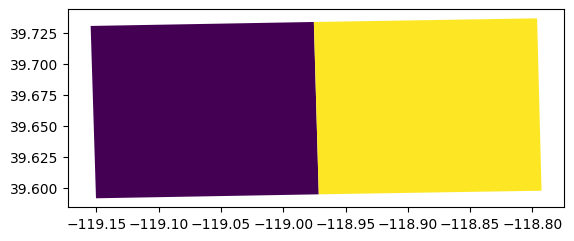

In [ ]:
# Convert into GeoDataFrame and visualize embeddings
index_gdf = gpd.GeoDataFrame(index, geometry = bboxs)
print(index_gdf.head())

# Visualize first dimension of embedding
index_gdf_first = gpd.GeoDataFrame(geometry = index_gdf['geometry'])
index_gdf_first['emb'] = index_gdf['embeddings'].apply(lambda x: x[0]) # Change 0 to visualize other dimensions

# Plot first embedding dimension
index_gdf_first.plot(column = 'emb')
plt.show()

In [ ]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(rgb="band", vmin=0, vmax=2000, col_wrap=6)
    plt.show()